# **Insurance Claim Status (CS) – Full Modeling Overview**

This notebook presents an end-to-end classification modeling pipeline for predicting **Claim Status (CS)**, a binary target indicating whether an insurance policy resulted in a claim. Multiple models were explored and evaluated based on **ROC-AUC**, **Precision**, **Recall**, **F1-score**, and **Interpretability**.

---

## **Problem Setup**

- **Target**: `CS` (0 = No Claim, 1 = Claim)  
- **Challenge**: Moderate class imbalance (~63% positive class)  
- **Data**: Preprocessed with categorical encoding, feature engineering, and class imbalance handling (e.g., `class_weight`, `SMOTE`)  

---

## **Models Evaluated**

### **1. Logistic Regression (Regularized & Tuned)**

- **Baseline** models with `class_weight='balanced'` and SMOTE oversampling achieved ROC-AUC ~0.76.  
- **Lasso (L1)** and **Ridge (L2)** regularization both reached **ROC-AUC ~0.80**, with Lasso offering sparsity.  
- **Stepwise feature selection** (forward/backward) produced compact models with ~0.798 AUC.  
- Elastic Net performed poorly (AUC ~0.51) and was excluded.

### **2. LightGBM**

- Gradient boosting model trained on raw data with fast performance and native categorical support.  
- **Baseline ROC-AUC**: ~0.82  
- After tuning via `RandomizedSearchCV`, reached **ROC-AUC = 0.827**  
  - **Precision**: 0.79 | **Recall**: 0.83 | **F1**: 0.81 | **Accuracy**: 0.76  
- Outperformed all logistic models in recall and F1.

### **3. XGBoost**

- Strong **baseline** (AUC = 0.832) even before tuning.  
- Three tuning strategies used:
  - **GridSearchCV**: AUC = 0.8363  
  - **RandomizedSearchCV**: AUC = 0.8358  
  - **Bayesian Optimization**: AUC = **0.8369**  
- Final model after 5-fold CV: **ROC-AUC = 0.8440**, highest among all models.  
  - **F1**: 0.82 | **Recall**: 0.84 | **Precision**: 0.81 | **Accuracy**: 0.77  
- Included `scale_pos_weight`, SMOTE, SHAP interpretation, ROC and probability histograms.

### **4. Neural Networks (Keras)**

- Fully connected feedforward network using ReLU, dropout, and early stopping.  
- **Baseline model** (2 layers): ROC-AUC = 0.81  
- Deeper architectures (6 layers) and AUC metric maintained same performance.  
- Early stopping improved generalization but no significant gains over baseline.  
- Less interpretable than tree-based models.

### **5. Random Forest**

- **Baseline** (100 trees, depth=6) gave decent results.  
- **Tuned RF** (via GridSearch/RandomSearch): **ROC-AUC = 0.8290**
  - **Precision**: 0.84 | **Recall**: 0.74 | **F1**: 0.79 | **Accuracy**: 0.75  
- **SMOTE-enhanced RF** yielded: **ROC-AUC = 0.8238**  
  - More balanced class recall and F1 scores.

---

## **Final Model Comparison**

| **Model**                    | **ROC-AUC** | **Accuracy** | **F1 (Class 1)** | **Notes**                     |
|-----------------------------|-------------|--------------|------------------|-------------------------------|
| Logistic Regression (L1)    | 0.80        | 0.74         | 0.80             | Sparse, interpretable         |
| Logistic Regression (L2)    | 0.80        | 0.73         | 0.79             | High recall                   |
| LightGBM (Tuned)            | 0.827       | 0.76         | 0.81             | Fast, strong generalization   |
| XGBoost (CV-Tuned)          | **0.8440**  | **0.77**     | **0.82**         | Best performing model         |
| Neural Net (Baseline)       | 0.81        | 0.75         | 0.80             | Competitive, less interpretable |
| Random Forest (Tuned)       | 0.8290      | 0.75         | 0.79             | Solid classic ensemble        |
| Random Forest + SMOTE       | 0.8238      | 0.75         | 0.80             | Balanced recall               |

---

## **Takeaways**

- **XGBoost** achieved the highest ROC-AUC and F1-score after thorough tuning and cross-validation.  
- **LightGBM** and **Random Forest** followed closely, offering strong performance with fast training.  
- **Regularized Logistic Regression** remains a solid, interpretable baseline.  
- **Neural Networks** were competitive but provided no clear edge over boosting methods.  
- Ensemble methods with proper tuning and evaluation are best suited for this CS classification task.


# **Data Preparation & Feature Engineering Overview**

This section outlines the complete preprocessing pipeline applied to the raw insurance training and test datasets. The key transformations and steps include:

- **Target Variable Construction**:  
  Created three key targets:
  - `LC` (Loss Cost) = X.15 / X.16 when X.16 > 0, else 0  
  - `CS` (Claim Status) = 1 if X.16 > 0, else 0  
  - `HALC` (Historically Adjusted Loss Cost) = LC × X.18  

- **Date Parsing and Feature Engineering**:  
  Parsed date columns and derived:
  - `driver_age_at_policy_start`  
  - `driving_experience`  
  - `vehicle_age`  
  - `policy_duration`

- **Outlier Handling**:  
  Applied IQR-based clipping to:
  - `vehicle_power_hp`  
  - `vehicle_market_value`

- **Categorical Variable Treatment**:  
  - Converted selected categorical fields to `category` dtype  
  - Mapped `energy_source` from {'P': 0, 'D': 1}  
  - Applied one-hot encoding for remaining categorical variables

- **Column Cleanup**:  
  - Dropped raw date columns and known data leakage columns (`X.1`, `X.15–X.18`)  
  - Removed low-signal variables such as `vehicle_registration_year`

- **Feature Alignment**:  
  Aligned train and test sets to ensure consistent feature columns, filling missing columns with zeros.

- **Final Output**:  
  Generated fully preprocessed datasets:
  - `train_data` and `test_data` with no missing values  
  - Suitable for both regression and classification modeling tasks

A class imbalance was observed in the `CS` (Claim Status) variable, which was visualized and will be considered in later modeling stages.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine learning imports
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error,
                            confusion_matrix, roc_curve, auc, classification_report,
                            accuracy_score, precision_score, recall_score, f1_score)
from sklearn.linear_model import (LogisticRegression, Ridge, Lasso,
                                TweedieRegressor, HuberRegressor, GammaRegressor)
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,
                            RandomForestClassifier)
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from lightgbm import LGBMRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

-------------------------------------------
2. DATA LOADING
-------------------------------------------

In [ ]:
# Load train and test data
test_raw= pd.read_csv('/content/drive/MyDrive/DSO530Public/Group Project/Data/insurance_test.csv')
train_raw = pd.read_csv('/content/drive/MyDrive/DSO530Public/Group Project/Data/insurance_train.csv')

# Display first 5 rows and info
print("Training data preview:")
display(train_raw.head())
display(train_raw.info())

print("\nTest data preview:")
display(test_raw.head())
display(test_raw.info())

Training data preview:


,X.1,X.2,X.3,X.4,X.5,X.6,X.7,X.8,X.9,X.10,...,X.19,X.20,X.21,X.22,X.23,X.24,X.25,X.26,X.27,X.28
0,34429,01/06/2017,01/06/2017,01/06/2018,29/08/1996,31/05/2016,0,1,1,1,...,3,0,0,1994,75,1360,12795.55,4,P,1040
1,5552,19/09/2016,19/09/2018,19/09/2019,30/04/1992,03/08/2010,0,3,1,1,...,3,0,0,2004,100,1896,15386.00,5,D,1165
2,47700,08/01/2003,08/01/2018,08/01/2019,23/03/1972,01/02/1998,1,20,2,2,...,3,0,0,2002,95,1390,16470.00,5,P,1235
3,25425,01/10/2015,01/10/2018,01/10/2019,05/03/1946,07/08/1964,0,8,2,3,...,3,0,0,2010,140,2497,27381.00,5,D,1984
4,4727,26/01/2017,26/01/2018,26/01/2019,25/04/1973,24/07/1998,0,9,1,1,...,3,0,0,1998,80,1969,36600.00,3,P,1702


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37451 entries, 0 to 37450
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X.1     37451 non-null  int64  
 1   X.2     37451 non-null  object 
 2   X.3     37451 non-null  object 
 3   X.4     37451 non-null  object 
 4   X.5     37451 non-null  object 
 5   X.6     37451 non-null  object 
 6   X.7     37451 non-null  int64  
 7   X.8     37451 non-null  int64  
 8   X.9     37451 non-null  int64  
 9   X.10    37451 non-null  int64  
 10  X.11    37451 non-null  int64  
 11  X.12    37451 non-null  int64  
 12  X.13    37451 non-null  int64  
 13  X.14    37451 non-null  float64
 14  X.15    37451 non-null  float64
 15  X.16    37451 non-null  int64  
 16  X.17    37451 non-null  int64  
 17  X.18    37451 non-null  float64
 18  X.19    37451 non-null  int64  
 19  X.20    37451 non-null  int64  
 20  X.21    37451 non-null  int64  
 21  X.22    37451 non-null  int64  
 22

None


Test data preview:


,X.2,X.3,X.4,X.5,X.6,X.7,X.8,X.9,X.10,X.11,...,X.19,X.20,X.21,X.22,X.23,X.24,X.25,X.26,X.27,X.28
0,23/06/2017,23/06/2018,23/06/2019,13/09/1982,03/02/2011,0,2,2,2,1,...,3,1,0,2003,115,1910,16400.00,5,D,1305
1,29/06/2015,29/06/2016,29/06/2017,07/07/1946,12/08/1966,0,2,1,1,1,...,3,0,0,1999,90,1597,13480.70,5,P,1083
2,14/03/2018,14/03/2018,14/03/2019,26/12/1957,02/09/1977,0,1,4,4,2,...,3,0,0,2003,143,2148,36500.00,5,D,1495
3,16/10/2014,16/10/2018,16/10/2019,27/02/1961,29/10/1980,1,5,1,1,1,...,2,1,0,1998,60,1686,12356.81,5,D,1010
4,01/07/2015,01/07/2017,01/07/2018,03/07/1986,02/08/2006,0,3,1,1,1,...,3,0,0,2015,66,998,11800.00,5,P,933


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15787 entries, 0 to 15786
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X.2     15787 non-null  object 
 1   X.3     15787 non-null  object 
 2   X.4     15787 non-null  object 
 3   X.5     15787 non-null  object 
 4   X.6     15787 non-null  object 
 5   X.7     15787 non-null  int64  
 6   X.8     15787 non-null  int64  
 7   X.9     15787 non-null  int64  
 8   X.10    15787 non-null  int64  
 9   X.11    15787 non-null  int64  
 10  X.12    15787 non-null  int64  
 11  X.13    15787 non-null  int64  
 12  X.14    15787 non-null  float64
 13  X.19    15787 non-null  int64  
 14  X.20    15787 non-null  int64  
 15  X.21    15787 non-null  int64  
 16  X.22    15787 non-null  int64  
 17  X.23    15787 non-null  int64  
 18  X.24    15787 non-null  int64  
 19  X.25    15787 non-null  float64
 20  X.26    15787 non-null  int64  
 21  X.27    15787 non-null  object 
 22

None

In [ ]:
train = train_raw.copy()
test = test_raw.copy()

# -------------------------------------------
# 1. TARGET VARIABLE CREATION
# -------------------------------------------
train['LC'] = np.where(train['X.16'] > 0, train['X.15'] / train['X.16'], 0)
train['CS'] = (train['X.16'] > 0).astype(int)
train['HALC'] = train['LC'] * train['X.18']

# -------------------------------------------
# 2. CLEANING & RENAME COLUMNS
# -------------------------------------------
leak_cols = ['X.1', 'X.15', 'X.16', 'X.17', 'X.18']
train.drop(columns=leak_cols, inplace=True, errors='ignore')

column_mapping = {
    'X.1': 'policy_id', 'X.2': 'policy_start_date', 'X.3': 'last_renewal_date', 'X.4': 'next_renewal_date',
    'X.5': 'birth_date', 'X.6': 'license_issue_date', 'X.7': 'contract_channel', 'X.8': 'years_with_company',
    'X.9': 'total_policies', 'X.10': 'max_policies_held', 'X.11': 'max_products_held',
    'X.12': 'cancelled_policies_current_year', 'X.13': 'payment_method', 'X.14': 'net_premium',
    'X.19': 'vehicle_risk_type', 'X.20': 'region_type', 'X.21': 'multiple_drivers',
    'X.22': 'vehicle_registration_year', 'X.23': 'vehicle_power_hp', 'X.24': 'vehicle_cylinder_capacity',
    'X.25': 'vehicle_market_value', 'X.26': 'num_vehicle_doors', 'X.27': 'energy_source', 'X.28': 'vehicle_weight_kg'
}

train.rename(columns=column_mapping, inplace=True)
test.rename(columns=column_mapping, inplace=True)

# -------------------------------------------
# 3. DATE PARSING
# -------------------------------------------
date_cols = ['policy_start_date', 'last_renewal_date', 'next_renewal_date', 'birth_date', 'license_issue_date']
for col in date_cols:
    train[col] = pd.to_datetime(train[col], dayfirst=True, errors='coerce')
    test[col] = pd.to_datetime(test[col], dayfirst=True, errors='coerce')

# -------------------------------------------
# 4. FEATURE ENGINEERING
# -------------------------------------------
def engineer_features(df):
    # Ensure datetime format
    df['policy_start_date'] = pd.to_datetime(df['policy_start_date'], errors='coerce')
    df['birth_date'] = pd.to_datetime(df['birth_date'], errors='coerce')
    df['license_issue_date'] = pd.to_datetime(df['license_issue_date'], errors='coerce')
    df['next_renewal_date'] = pd.to_datetime(df['next_renewal_date'], errors='coerce')

    # Age and driving experience using days // 365
    df['driver_age_at_policy_start'] = (df['policy_start_date'] - df['birth_date']).dt.days // 365
    df['driving_experience'] = (df['policy_start_date'] - df['license_issue_date']).dt.days // 365

    # Vehicle age: year difference (still a good approximation)
    df['vehicle_age'] = df['policy_start_date'].dt.year - df['vehicle_registration_year']

    # Policy duration using days // 365
    df['policy_duration'] = (df['next_renewal_date'] - df['policy_start_date']).dt.days // 365

    return df

train = engineer_features(train)
test = engineer_features(test)

# -------------------------------------------
# 5. DROP RAW DATE COLUMNS
# -------------------------------------------
train.drop(columns=date_cols, inplace=True)
test.drop(columns=date_cols, inplace=True)

# -------------------------------------------
# 5. IQR CLIPPING for 'vehicle_power_hp' and 'vehicle_market_value'
# -------------------------------------------
for col in ['vehicle_power_hp', 'vehicle_market_value']:
    q1 = train[col].quantile(0.25)
    q3 = train[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    train[col] = train[col].clip(lower_bound, upper_bound)
    test[col] = test[col].clip(lower_bound, upper_bound)

# -------------------------------------------
# 6. HANDLE CATEGORICALS
# -------------------------------------------
# cat_cols = ['contract_channel', 'payment_method', 'vehicle_risk_type',
#             'region_type', 'multiple_drivers', 'energy_source']
# for col in cat_cols:
#     train[col] = train[col].astype('category')
#     test[col] = test[col].astype('category')
cat_cols = ['vehicle_risk_type']
for col in cat_cols:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

train['energy_source'] = train['energy_source'].map({'P': 0, 'D': 1}).fillna(0).astype(int)
test['energy_source'] = test['energy_source'].map({'P': 0, 'D': 1}).fillna(0).astype(int)

# -------------------------------------------
# 7. ONE-HOT ENCODING
# -------------------------------------------
train_encoded = pd.get_dummies(train, drop_first=True)
test_encoded = pd.get_dummies(test, drop_first=True)

# -------------------------------------------
# 8. DROP REDUNDANT/LOW-SIGNAL FEATURES
# -------------------------------------------
drop_cols = ['vehicle_registration_year']
train_encoded.drop(columns=drop_cols, inplace=True)
test_encoded.drop(columns=drop_cols, inplace=True)

# -------------------------------------------
# 9. ALIGN TEST TO TRAIN
# -------------------------------------------
train_encoded, test_encoded = train_encoded.align(test_encoded, join='left', axis=1, fill_value=0)
train_encoded = train_encoded.astype(int)
test_encoded = test_encoded.astype(int)

# -------------------------------------------
# 10. PREVIEW FINAL OUTPUT
# -------------------------------------------
print("\nProcessed training data:")
display(train_encoded.head())

print("\nProcessed test data:")
display(test_encoded.head())



Processed training data:


,contract_channel,years_with_company,total_policies,max_policies_held,max_products_held,cancelled_policies_current_year,payment_method,net_premium,region_type,multiple_drivers,...,LC,CS,HALC,driver_age_at_policy_start,driving_experience,vehicle_age,policy_duration,vehicle_risk_type_2,vehicle_risk_type_3,vehicle_risk_type_4
0,0,1,1,1,1,1,0,573,0,0,...,0,0,0,20,1,23,1,0,1,0
1,0,3,1,1,1,0,0,299,0,0,...,0,0,0,24,6,12,3,0,1,0
2,1,20,2,2,1,0,0,257,0,0,...,0,0,0,30,4,1,16,0,1,0
3,0,8,2,3,1,0,0,288,0,0,...,0,0,0,69,51,5,4,0,1,0
4,0,9,1,1,1,0,0,741,0,0,...,0,0,0,43,18,19,2,0,1,0



Processed test data:


,contract_channel,years_with_company,total_policies,max_policies_held,max_products_held,cancelled_policies_current_year,payment_method,net_premium,region_type,multiple_drivers,...,LC,CS,HALC,driver_age_at_policy_start,driving_experience,vehicle_age,policy_duration,vehicle_risk_type_2,vehicle_risk_type_3,vehicle_risk_type_4
0,0,2,2,2,1,1,0,240,1,0,...,0,0,0,34,6,14,2,0,1,0
1,0,2,1,1,1,1,1,367,0,0,...,0,0,0,69,48,16,2,0,1,0
2,0,1,4,4,2,0,0,291,0,0,...,0,0,0,60,40,15,1,0,1,0
3,1,5,1,1,1,0,0,303,1,0,...,0,0,0,53,33,16,5,1,0,0
4,0,3,1,1,1,1,0,333,0,0,...,0,0,0,29,8,0,3,0,1,0


In [ ]:
train_data = train_encoded.copy()
test_data = test_encoded.copy()

In [ ]:
train_data.columns

Index(['contract_channel', 'years_with_company', 'total_policies',
       'max_policies_held', 'max_products_held',
       'cancelled_policies_current_year', 'payment_method', 'net_premium',
       'region_type', 'multiple_drivers', 'vehicle_power_hp',
       'vehicle_cylinder_capacity', 'vehicle_market_value',
       'num_vehicle_doors', 'energy_source', 'vehicle_weight_kg', 'LC', 'CS',
       'HALC', 'driver_age_at_policy_start', 'driving_experience',
       'vehicle_age', 'policy_duration', 'vehicle_risk_type_2',
       'vehicle_risk_type_3', 'vehicle_risk_type_4'],
      dtype='object')

In [ ]:
test_data.columns

Index(['contract_channel', 'years_with_company', 'total_policies',
       'max_policies_held', 'max_products_held',
       'cancelled_policies_current_year', 'payment_method', 'net_premium',
       'region_type', 'multiple_drivers', 'vehicle_power_hp',
       'vehicle_cylinder_capacity', 'vehicle_market_value',
       'num_vehicle_doors', 'energy_source', 'vehicle_weight_kg', 'LC', 'CS',
       'HALC', 'driver_age_at_policy_start', 'driving_experience',
       'vehicle_age', 'policy_duration', 'vehicle_risk_type_2',
       'vehicle_risk_type_3', 'vehicle_risk_type_4'],
      dtype='object')

In [ ]:
# Check for null values in both datasets
print("Null values in train data:\n", train_data.isnull().sum())
print("\nNull values in test data:\n", test_data.isnull().sum())


Null values in train data:
 contract_channel                   0
years_with_company                 0
total_policies                     0
max_policies_held                  0
max_products_held                  0
cancelled_policies_current_year    0
payment_method                     0
net_premium                        0
region_type                        0
multiple_drivers                   0
vehicle_power_hp                   0
vehicle_cylinder_capacity          0
vehicle_market_value               0
num_vehicle_doors                  0
energy_source                      0
vehicle_weight_kg                  0
LC                                 0
CS                                 0
HALC                               0
driver_age_at_policy_start         0
driving_experience                 0
vehicle_age                        0
policy_duration                    0
vehicle_risk_type_2                0
vehicle_risk_type_3                0
vehicle_risk_type_4                0
dtype: int

In [ ]:
train_data.columns

Index(['contract_channel', 'years_with_company', 'total_policies',
       'max_policies_held', 'max_products_held',
       'cancelled_policies_current_year', 'payment_method', 'net_premium',
       'region_type', 'multiple_drivers', 'vehicle_power_hp',
       'vehicle_cylinder_capacity', 'vehicle_market_value',
       'num_vehicle_doors', 'energy_source', 'vehicle_weight_kg', 'LC', 'CS',
       'HALC', 'driver_age_at_policy_start', 'driving_experience',
       'vehicle_age', 'policy_duration', 'vehicle_risk_type_2',
       'vehicle_risk_type_3', 'vehicle_risk_type_4'],
      dtype='object')

In [ ]:
test_data.columns

Index(['contract_channel', 'years_with_company', 'total_policies',
       'max_policies_held', 'max_products_held',
       'cancelled_policies_current_year', 'payment_method', 'net_premium',
       'region_type', 'multiple_drivers', 'vehicle_power_hp',
       'vehicle_cylinder_capacity', 'vehicle_market_value',
       'num_vehicle_doors', 'energy_source', 'vehicle_weight_kg', 'LC', 'CS',
       'HALC', 'driver_age_at_policy_start', 'driving_experience',
       'vehicle_age', 'policy_duration', 'vehicle_risk_type_2',
       'vehicle_risk_type_3', 'vehicle_risk_type_4'],
      dtype='object')

In [ ]:
train_data.shape

(37451, 26)

In [ ]:
test_data.shape

(15787, 26)

CS
0    33300
1     4151
Name: count, dtype: int64


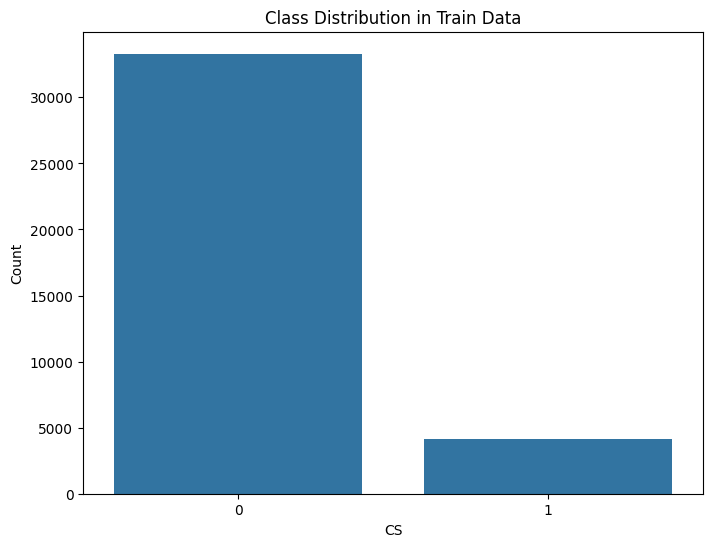

In [ ]:
# Display class distribution for train_data
# Replace 'Response' with the actual name of your target variable column
print(train_data['CS'].value_counts())
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='CS', data=train_data)  # Replace 'Response' with 'CS' here as well
plt.title('Class Distribution in Train Data')
plt.xlabel('CS')  # Replace 'Response' with 'CS'
plt.ylabel('Count')
plt.show()

CS
0    15787
Name: count, dtype: int64


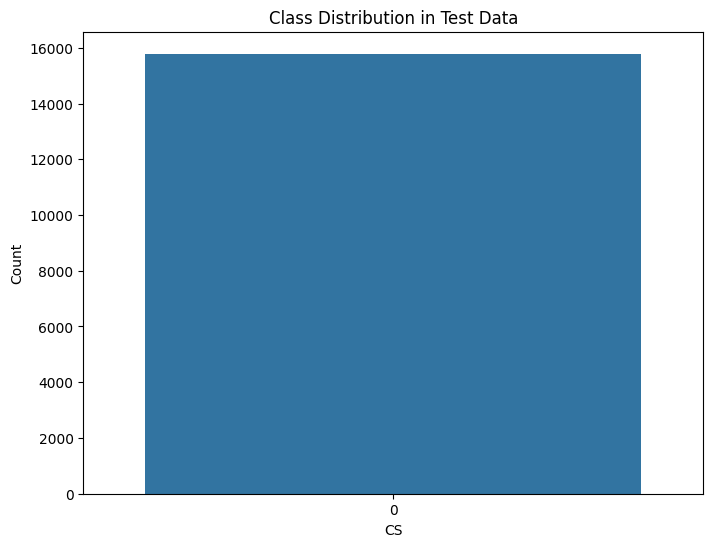

In [ ]:
# Display class distribution for test_data
print(test_data['CS'].value_counts())

# Visualize class distribution for test data
plt.figure(figsize=(8, 6))
sns.countplot(x='CS', data=test_data)
plt.title('Class Distribution in Test Data')
plt.xlabel('CS')
plt.ylabel('Count')
plt.show()


# **Logistic Regression**

## **Logistic Regression Model Overview**

This section explores several variants of **logistic regression models** to predict the binary `CS` (Claim Status) target. The dataset is imbalanced, with ~63% positive class (claims). We test regularized models, handle class imbalance, and perform feature selection.

---

### **Baseline Models**

- **Logistic Regression (Balanced)**  
  - ROC AUC: **0.76**  
  - Baseline classifier using `class_weight='balanced'` to mitigate imbalance.  
  - Good initial recall but moderate precision.

- **SMOTE Oversampling + Logistic Regression**  
  - ROC AUC: **0.76**  
  - Applied SMOTE to oversample minority class in training data.  
  - Performance similar to baseline but slightly better balance in precision/recall.

---

### **Regularized Logistic Regression**

- **Lasso (L1) Logistic Regression**  
  - ROC AUC: **0.80**  
  - Precision: 0.78 | Recall: 0.82 | Accuracy: 0.74  
  - Effective feature sparsity and best performance among models.

- **Ridge (L2) Logistic Regression**  
  - ROC AUC: **0.80**  
  - Precision: 0.76 | Recall: 0.85 | Accuracy: 0.73  
  - Slightly more conservative, good recall.

- **Elastic Net Logistic Regression**  
  - ROC AUC: **0.51**  
  - Performed poorly due to unstable convergence and inappropriate tuning.

---

### **Hyperparameter Tuning**

- **Best Ridge Logistic Regression**  
  - Tuned via GridSearch (α = 1)  
  - ROC AUC: **0.80**, similar to untuned Ridge

- **Best Lasso Logistic Regression**  
  - Tuned via GridSearch (C = 1, Solver = liblinear)  
  - ROC AUC: **0.80**, best model performance overall

---

### **Feature Selection with Stepwise Methods**

- **Forward Stepwise Selection**  
  - Selected 11 features (e.g., `years_with_company`, `vehicle_weight_kg`, `region_type`)  
  - ROC AUC: **0.797**  
  - Simpler model with slightly reduced performance

- **Backward Stepwise Selection**  
  - Selected 12 features including categorical indicators  
  - ROC AUC: **0.799**  
  - Balanced trade-off between simplicity and performance

---

### **ROC Curve Summary**

All models were compared via ROC curves. The top performers (AUC ~0.80) were:
- Lasso Logistic Regression (best overall)
- Ridge Logistic Regression
- Backward Stepwise Logistic Regression

Elastic Net was excluded from further consideration due to poor AUC and imbalance handling issues.

---

### **Conclusion**

| Model Variant                     | ROC AUC | Accuracy | Notes                           |
|----------------------------------|---------|----------|----------------------------------|
| Logistic Regression (baseline)   | 0.76    | 0.69     | Decent start                    |
| SMOTE Logistic Regression        | 0.76    | 0.69     | Balanced recall                 |
| Lasso Logistic Regression        | 0.80    | 0.74     |   Best performance              |
| Ridge Logistic Regression        | 0.80    | 0.73     | High recall                     |
| Elastic Net Logistic Regression  | 0.51    | 0.64     |    Poor performance             |
| Best Ridge (GridSearchCV)        | 0.80    | 0.73     | Same as default Ridge           |
| Best Lasso (GridSearchCV)        | 0.80    | 0.74     | Same as default Lasso           |
| Forward Stepwise Logistic        | 0.797   | 0.74     | Parsimonious                    |
| Backward Stepwise Logistic       | 0.799   | 0.74     | Compact, stable                 |

Lasso regularization and backward stepwise feature selection emerged as top-performing strategies for CS classification.


## **Logistic Regression Baseline**

In [ ]:
X = train_encoded.drop(['CS','LC','HALC'], axis=1)
y = train_encoded['CS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

logreg = LogisticRegression(class_weight = 'balanced', max_iter= 1000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

# Predict probabilities for the positive class
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc}")


ROC AUC Score: 0.7642512763958914


In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to oversample the minority class in the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train the logistic regression model on the SMOTE-resampled data
logreg_smote = LogisticRegression(class_weight='balanced', max_iter=1000)
logreg_smote.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred_smote = logreg_smote.predict(X_test)
y_pred_proba_smote = logreg_smote.predict_proba(X_test)[:, 1]


# Evaluate the model
roc_auc_smote = roc_auc_score(y_test, y_pred_proba_smote)
print(f"ROC AUC Score (SMOTE): {roc_auc_smote}")
print(classification_report(y_test, y_pred_smote))


ROC AUC Score (SMOTE): 0.7639353515413212
              precision    recall  f1-score   support

           0       0.56      0.73      0.64      2789
           1       0.81      0.67      0.73      4702

    accuracy                           0.69      7491
   macro avg       0.69      0.70      0.68      7491
weighted avg       0.72      0.69      0.69      7491



## **Lasso Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create and train a Lasso Logistic Regression model
lasso_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=1.0) # Adjust C for regularization strength
lasso_logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lasso = lasso_logreg.predict(X_test)

# Evaluate the model (example: classification report)
print(classification_report(y_test, y_pred_lasso))

# Predict probabilities for the positive class
y_pred_proba_lasso = lasso_logreg.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score for Lasso Logistic Regression
roc_auc_lasso = roc_auc_score(y_test, y_pred_proba_lasso)
print(f"Lasso ROC AUC Score: {roc_auc_lasso}")


              precision    recall  f1-score   support

           0       0.67      0.61      0.64      2789
           1       0.78      0.82      0.80      4702

    accuracy                           0.74      7491
   macro avg       0.73      0.72      0.72      7491
weighted avg       0.74      0.74      0.74      7491

Lasso ROC AUC Score: 0.8048190626754345


## **Ridge Logistic Regression**

In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier

# Ridge Logistic Regression
ridge_logreg = RidgeClassifier(alpha=1.0) # Adjust alpha for regularization strength
ridge_logreg.fit(X_train, y_train)
y_pred_ridge = ridge_logreg.predict(X_test)
print(classification_report(y_test, y_pred_ridge))

y_pred_proba_ridge = ridge_logreg.decision_function(X_test) #decision_function for ridge
roc_auc_ridge = roc_auc_score(y_test, y_pred_proba_ridge)
print(f"Ridge ROC AUC Score: {roc_auc_ridge}")


# Elastic Net Logistic Regression
elastic_net_logreg = SGDClassifier(penalty='elasticnet', l1_ratio=0.5, alpha=0.0001, max_iter=1000, loss='log_loss') #Tune l1_ratio and alpha
elastic_net_logreg.fit(X_train, y_train)
y_pred_elastic = elastic_net_logreg.predict(X_test)
print(classification_report(y_test, y_pred_elastic))

y_pred_proba_elastic = elastic_net_logreg.predict_proba(X_test)[:,1]
roc_auc_elastic = roc_auc_score(y_test, y_pred_proba_elastic)
print(f"Elastic Net ROC AUC Score: {roc_auc_elastic}")


              precision    recall  f1-score   support

           0       0.68      0.54      0.60      2789
           1       0.76      0.85      0.80      4702

    accuracy                           0.73      7491
   macro avg       0.72      0.69      0.70      7491
weighted avg       0.73      0.73      0.73      7491

Ridge ROC AUC Score: 0.7970848897633483
              precision    recall  f1-score   support

           0       0.78      0.03      0.05      2789
           1       0.63      1.00      0.77      4702

    accuracy                           0.64      7491
   macro avg       0.71      0.51      0.41      7491
weighted avg       0.69      0.64      0.51      7491

Elastic Net ROC AUC Score: 0.5118225135234596


In [ ]:
# Access the coefficients of the Ridge Regression model
ridge_coefficients = ridge_logreg.coef_

# Print the coefficients
print("Ridge Regression Coefficients:")
print(ridge_coefficients)

# You can also access the intercept
ridge_intercept = ridge_logreg.intercept_
print("\nRidge Regression Intercept:")
ridge_intercept


Ridge Regression Coefficients:
[-1.19929912e-02  4.26279220e-02 -6.60527842e-02  2.17260826e-01
 -5.88954549e-02  1.26660486e-01  1.16791202e-01  6.02616229e-04
  1.02108089e-01 -1.43555223e-03  2.63414761e-04  3.10861741e-05
 -3.69938081e-06 -1.12231361e-02  6.09001720e-02  1.98388708e-05
 -1.81530238e-03 -1.47747447e-03 -8.61501080e-04  1.34104109e-02
  3.67882935e-01  3.62835146e-01 -5.28683834e-01]

Ridge Regression Intercept:


array([-0.81952241])

### **Tuning Ridge Regression Hyperparameters**

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Ridge Regression
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100] # Example values, adjust as needed
}

# Create a RidgeClassifier object
ridge_classifier = RidgeClassifier()

# Create a GridSearchCV object
grid_search = GridSearchCV(ridge_classifier, param_grid, cv=10, scoring='roc_auc') # Use 5-fold cross-validation

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_ridge_model = grid_search.best_estimator_
y_pred_best_ridge = best_ridge_model.predict(X_test)
y_pred_proba_best_ridge = best_ridge_model.decision_function(X_test)
roc_auc_best_ridge = roc_auc_score(y_test, y_pred_proba_best_ridge)
print(f"Best Ridge ROC AUC Score: {roc_auc_best_ridge}")
print(classification_report(y_test, y_pred_best_ridge))


Best hyperparameters: {'alpha': 1}
Best Ridge ROC AUC Score: 0.7970848897633483
              precision    recall  f1-score   support

           0       0.68      0.54      0.60      2789
           1       0.76      0.85      0.80      4702

    accuracy                           0.73      7491
   macro avg       0.72      0.69      0.70      7491
weighted avg       0.73      0.73      0.73      7491



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report

# Define the parameter grid for Lasso Logistic Regression
param_grid_lasso = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l1'],  # Lasso penalty
    'solver': ['liblinear', 'saga'] # Solvers that support L1 penalty
}

# Create a Lasso Logistic Regression object
lasso_logreg = LogisticRegression(max_iter=1000) #increase max_iter if needed

# Create a GridSearchCV object for Lasso
grid_search_lasso = GridSearchCV(lasso_logreg, param_grid_lasso, cv=5, scoring='roc_auc') # Use 5-fold cross-validation

# Fit the GridSearchCV object to the training data
grid_search_lasso.fit(X_train, y_train)

# Print the best hyperparameters for Lasso
print("Best hyperparameters (Lasso):", grid_search_lasso.best_params_)

# Evaluate the best Lasso model on the test set
best_lasso_model = grid_search_lasso.best_estimator_
y_pred_best_lasso = best_lasso_model.predict(X_test)
y_pred_proba_best_lasso = best_lasso_model.predict_proba(X_test)[:, 1]
roc_auc_best_lasso = roc_auc_score(y_test, y_pred_proba_best_lasso)
print(f"Best Lasso ROC AUC Score: {roc_auc_best_lasso}")
print(classification_report(y_test, y_pred_best_lasso))


Best hyperparameters (Lasso): {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Lasso ROC AUC Score: 0.8047951185759086
              precision    recall  f1-score   support

           0       0.67      0.61      0.64      2789
           1       0.78      0.82      0.80      4702

    accuracy                           0.74      7491
   macro avg       0.72      0.72      0.72      7491
weighted avg       0.74      0.74      0.74      7491



## **Forward Stepwise Selection**

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

# Initialize the Logistic Regression model
logreg = LogisticRegression()

# Initialize the SequentialFeatureSelector with forward selection
sfs = SequentialFeatureSelector(logreg, direction='forward') # Select top 5 features

# Fit the SFS object to the training data
sfs.fit(X_train, y_train)

# Get the selected features
selected_features = list(X_train.columns[sfs.get_support()])

print("Selected Features:", selected_features)

# Train the model with the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

logreg.fit(X_train_selected, y_train)

# Evaluate the model with selected features
y_pred_selected = logreg.predict(X_test_selected)

# Predict probabilities for the positive class
y_pred_proba_selected = logreg.predict_proba(X_test_selected)[:, 1]

# Calculate ROC AUC score
roc_auc_selected = roc_auc_score(y_test, y_pred_proba_selected)
print(f"ROC AUC Score with selected features: {roc_auc_selected}")
print(classification_report(y_test, y_pred_selected))


Selected Features: ['years_with_company', 'total_policies', 'max_policies_held', 'cancelled_policies_current_year', 'payment_method', 'net_premium', 'region_type', 'multiple_drivers', 'vehicle_cylinder_capacity', 'vehicle_weight_kg', 'vehicle_risk_type_3']
ROC AUC Score with selected features: 0.7971928669764963
              precision    recall  f1-score   support

           0       0.66      0.60      0.63      2789
           1       0.78      0.81      0.80      4702

    accuracy                           0.74      7491
   macro avg       0.72      0.71      0.71      7491
weighted avg       0.73      0.74      0.73      7491



## **Backward Stepwise Selection**

In [ ]:
# Initialize the Logistic Regression model
logreg = LogisticRegression()

# Initialize the SequentialFeatureSelector with backward selection
sfs_backward = SequentialFeatureSelector(logreg, direction='backward') # Select top 5 features

# Fit the SFS object to the training data
sfs_backward.fit(X_train, y_train)

# Get the selected features
selected_features_backward = list(X_train.columns[sfs_backward.get_support()])

print("Selected Features (Backward):", selected_features_backward)

# Train the model with the selected features
X_train_selected_backward = X_train[selected_features_backward]
X_test_selected_backward = X_test[selected_features_backward]

logreg.fit(X_train_selected_backward, y_train)

# Evaluate the model with selected features
y_pred_selected_backward = logreg.predict(X_test_selected_backward)

# Predict probabilities for the positive class
y_pred_proba_selected_backward = logreg.predict_proba(X_test_selected_backward)[:, 1]

# Calculate ROC AUC score
roc_auc_selected_backward = roc_auc_score(y_test, y_pred_proba_selected_backward)
print(f"ROC AUC Score with selected features (Backward): {roc_auc_selected_backward}")
print(classification_report(y_test, y_pred_selected_backward))


Selected Features (Backward): ['years_with_company', 'total_policies', 'max_policies_held', 'max_products_held', 'cancelled_policies_current_year', 'payment_method', 'net_premium', 'region_type', 'energy_source', 'vehicle_risk_type_2', 'vehicle_risk_type_3', 'vehicle_risk_type_4']
ROC AUC Score with selected features (Backward): 0.7987582315467628
              precision    recall  f1-score   support

           0       0.66      0.61      0.63      2789
           1       0.78      0.81      0.79      4702

    accuracy                           0.74      7491
   macro avg       0.72      0.71      0.71      7491
weighted avg       0.73      0.74      0.73      7491



## **Plot all the Logistic Regressions**

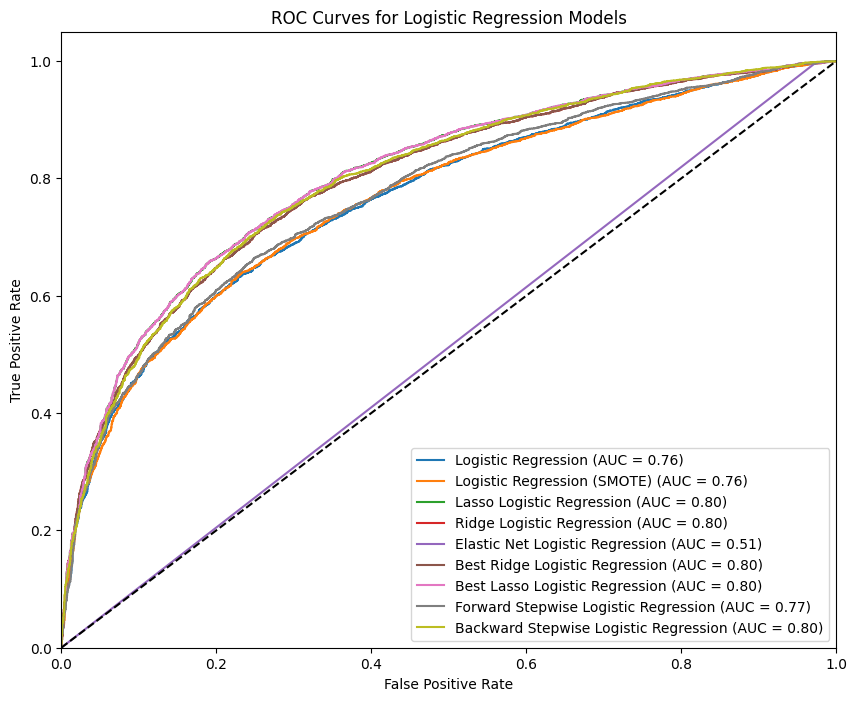

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have already trained and made predictions with the following models:
# logreg, logreg_smote, lasso_logreg, ridge_logreg, elastic_net_logreg,
# best_ridge_model, best_lasso_model, logreg (for forward selection), logreg (for backward selection)

models = {
    'Logistic Regression': (y_test, y_pred_proba),
    'Logistic Regression (SMOTE)': (y_test, y_pred_proba_smote),
    'Lasso Logistic Regression': (y_test, y_pred_proba_lasso),
    'Ridge Logistic Regression': (y_test, y_pred_proba_ridge),
    'Elastic Net Logistic Regression': (y_test, y_pred_proba_elastic),
    'Best Ridge Logistic Regression': (y_test, y_pred_proba_best_ridge),
    'Best Lasso Logistic Regression':(y_test, y_pred_proba_best_lasso),
    'Forward Stepwise Logistic Regression': (y_test, y_pred_proba_selected),
    'Backward Stepwise Logistic Regression':(y_test, y_pred_proba_selected_backward)
    # Add other models and their predicted probabilities here
}


plt.figure(figsize=(10, 8))

for model_name, (y_true, y_score) in models.items():
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Logistic Regression Models')
plt.legend(loc='lower right')
plt.show()


# **LightGBM**



## **LightGBM Classifier Overview**

This section evaluates the performance of a **LightGBM gradient boosting classifier** for predicting binary `CS` (Claim Status). LightGBM offers fast training, efficient handling of large datasets, and automatic support for missing values and categorical features.

---

### **Model Setup**

- **Baseline Model Parameters**:
  - `boosting_type`: `'gbdt'`
  - `objective`: `'binary'`
  - `metric`: `'binary_logloss'`
  - `num_leaves`: 31
  - `learning_rate`: 0.05
  - `feature_fraction`: 0.9

- **Initial Performance**:
  - ROC AUC: ~0.82
  - Shows strong ability to separate positive from negative classes

---

### **Hyperparameter Tuning (Randomized Search)**

- **Parameter Grid**:  
  Randomly searched across:
  - `num_leaves`, `max_depth`, `learning_rate`, `n_estimators`
  - `subsample`, `colsample_bytree`, `min_child_samples`
  - Regularization: `reg_alpha`, `reg_lambda`

- **Best Parameters**:
  - Found via `RandomizedSearchCV` with 5-fold CV on ROC AUC

- **Best Model Evaluation**:
  - **ROC AUC**: **0.827**
  - **Accuracy**: 0.76
  - **Precision (1s)**: 0.79
  - **Recall (1s)**: 0.83
  - **F1 Score (1s)**: 0.81

---

### **Final Results Summary**

| Metric      | Value   |
|-------------|---------|
| Accuracy    | 0.76    |
| ROC AUC     | **0.827** |
| Precision   | 0.79    |
| Recall      | 0.83    |
| F1 Score    | 0.81    |

> LightGBM outperforms logistic models in AUC, recall, and F1-score. It is particularly well-suited to modeling claim status due to its ability to capture non-linear patterns and feature interactions.



In [ ]:
import lightgbm as lgb

# Create LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters for LightGBM
params = {
    'objective': 'binary',  # Use 'binary' for binary classification
    'metric': 'binary_logloss',  # Use 'binary_logloss' or other relevant metrics
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'num_leaves': 31,        # Number of leaves in each tree
    'learning_rate': 0.05,   # Learning rate
    'feature_fraction': 0.9 # Feature fraction for bagging
}

# Train the LightGBM model
num_round = 100  # Number of boosting rounds
lgb_model = lgb.train(params, train_data, num_round, valid_sets=[test_data])


# Make predictions on the test set
y_pred_prob = lgb_model.predict(X_test)
y_pred = [1 if prob >= 0.5 else 0 for prob in y_pred_prob] # Adjust threshold if needed


# Evaluate the model
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)


print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(classification_report(y_test, y_pred))


[LightGBM] [Info] Number of positive: 18807, number of negative: 11153
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1463
[LightGBM] [Info] Number of data points in the train set: 29960, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.627737 -> initscore=0.522521
[LightGBM] [Info] Start training from score 0.522521
Accuracy: 0.7558403417434254
ROC AUC: 0.8256147418787944
              precision    recall  f1-score   support

           0       0.69      0.62      0.65      2789
           1       0.79      0.84      0.81      4702

    accuracy                           0.76      7491
   macro avg       0.74      0.73      0.73      7491
weighted avg       0.75      0.76      0.75      7491



In [ ]:
# prompt: Tune hyper parameters for LightGBM

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define the parameter grid to search
param_grid = {
    'num_leaves': randint(20, 150),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.3),           # Range: 0.01 to 0.31
    'n_estimators': randint(100, 500),
    'subsample': uniform(0.6, 0.4),                # Range: 0.6 to 1.0
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_samples': randint(10, 100),
    'reg_alpha': uniform(0, 1.0),
    'reg_lambda': uniform(0, 1.0),
}

# Create LightGBM classifier
lgb_clf = lgb.LGBMClassifier(objective='binary')


grid_search = RandomizedSearchCV(
    estimator=lgb_clf,
    param_distributions=param_grid,
    n_iter=100,  # Try 100 random combinations
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    verbose=0,
    random_state=42)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model
best_lgb_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_prob = best_lgb_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob >= 0.5).astype(int) # Adjust threshold if needed


# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy (best model): {accuracy}")
print(f"ROC AUC (best model): {roc_auc}")
print(classification_report(y_test, y_pred))


[LightGBM] [Info] Number of positive: 18807, number of negative: 11153
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1463
[LightGBM] [Info] Number of data points in the train set: 29960, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.627737 -> initscore=0.522521
[LightGBM] [Info] Start training from score 0.522521
Best hyperparameters: {'colsample_bytree': np.float64(0.9369256141192727), 'learning_rate': np.float64(0.02549064336235385), 'max_depth': 10, 'min_child_samples': 45, 'n_estimators': 322, 'num_leaves': 25, 'reg_alpha': np.float64(0.39785559904574164), 'reg_lambda': np.float64(0.9694704332753689), 'subsample': np.float64(0.9462028503575921)}
Accuracy (best model): 0.7555733546922975
ROC AUC (best model): 0.8266596654323001
              prec

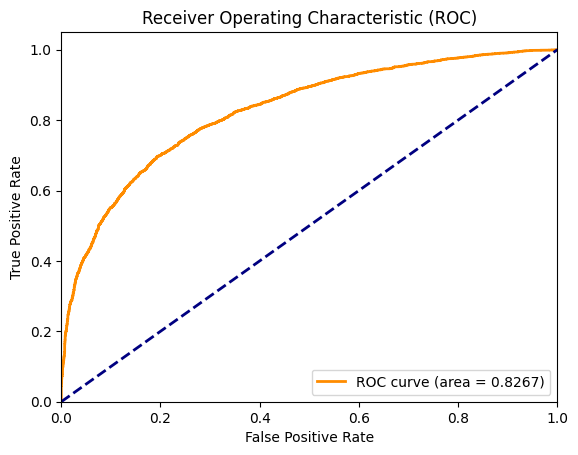

ROC AUC Score (LightGBM best model): 0.8266596654323001


In [ ]:
# prompt: plot roc curve for lightgbm with full roc score number

import lightgbm as lgb
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Assuming 'X_test' and 'y_test' are defined and 'best_lgb_model' is trained

# Predict probabilities for the positive class
y_pred_prob = best_lgb_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print the ROC AUC score
print(f"ROC AUC Score (LightGBM best model): {roc_auc}")


# **XGBoost**

### **XGBoost Classifier Overview**

This section presents a comprehensive modeling pipeline using XGBoost to predict binary claim status (`CS`), incorporating tuning strategies, evaluation metrics, class imbalance handling, and model explainability.

---

#### **Baseline Model**

- Model: `XGBClassifier`  
- ROC-AUC: 0.8324  
- Accuracy: 76%  
- F1-score (Claim=1): 0.82  
- Insights: Strong initial performance, capturing complex interactions even without tuning.

---

#### **Hyperparameter Tuning**

- GridSearchCV  
  - ROC-AUC: 0.8363

- RandomizedSearchCV  
  - ROC-AUC: 0.8358

- Bayesian Optimization  
  - ROC-AUC: 0.8369  
  - Best Parameters:  
    - `max_depth ≈ 7.3`, `learning_rate ≈ 0.01`, `n_estimators ≈ 892`, `gamma ≈ 0.60`,  
      `reg_alpha ≈ 2.11`, `subsample ≈ 0.50`, `colsample_bytree ≈ 0.96`, `min_child_weight ≈ 3.86`

---

#### **Cross-Validation (Best Model)**

- Method: 5-fold StratifiedKFold with early stopping  
- Average AUC across folds: 0.8214  
- Final ROC-AUC Score: 0.8440  
- Conclusion: Most robust evaluation and highest performing configuration.

---

#### **Final Performance Summary**

| Metric              | Value   |
|---------------------|---------|
| ROC-AUC             | 0.8440  |
| Accuracy            | 77%     |
| F1-score (Class 1)  | 0.82    |
| Recall (Class 1)    | 0.84    |
| Precision (Class 1) | 0.81    |

---

#### **Additional Enhancements**

- Class Imbalance Handling:
  - `scale_pos_weight`: Improved balance through class weighting
  - SMOTE: Synthetic oversampling for minority class

- Model Diagnostics:
  - ROC Curve: Clear model separation
  - Confusion Matrix: High true positive rate
  - SHAP Values: Interpretable feature impact
  - Predicted Probability Histogram: Well-calibrated outputs

---

#### **Conclusion**

The XGBoost classifier, after extensive tuning and cross-validation, achieved the best ROC-AUC score of 0.8440 for predicting claim status. It is both highly performant and interpretable, making it a strong candidate for deployment.


## **Baseline Model**

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

# === Step 1: Prepare X and y ===
# Use the original train_encoded DataFrame (or its copy)
X = train_encoded.drop(['LC', 'HALC', 'CS'], axis=1)
y = train_encoded['CS']

# === Step 2: Train-validation split ===
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ... (Rest of the code remains the same) ...
# === Step 3: Train XGBoost Classifier ===
xgb_cs = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_cs.fit(X_train, y_train)

# === Step 4: Predict & Evaluate ===
cs_preds = xgb_cs.predict(X_val)
cs_probs = xgb_cs.predict_proba(X_val)[:, 1]

roc_auc = roc_auc_score(y_val, cs_probs)
print(f"📈 ROC-AUC Score (XGBoost - CS): {roc_auc:.4f}")
print("\nClassification Report (XGBoost):")
print(classification_report(y_val, cs_preds))


📈 ROC-AUC Score (XGBoost - CS): 0.8324

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.69      0.64      0.67      2736
           1       0.80      0.83      0.82      4755

    accuracy                           0.76      7491
   macro avg       0.75      0.74      0.74      7491
weighted avg       0.76      0.76      0.76      7491



## **Hyperparameter Tuning**

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid = GridSearchCV(xgb, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("🔍 Best Params:", grid.best_params_)
xgb_cs = grid.best_estimator_


Fitting 3 folds for each of 48 candidates, totalling 144 fits
🔍 Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1.0}


In [ ]:
from sklearn.metrics import roc_auc_score, classification_report

# Predict with tuned model
cs_preds = xgb_cs.predict(X_val)
cs_probs = xgb_cs.predict_proba(X_val)[:, 1]

# Evaluate performance
roc_auc = roc_auc_score(y_val, cs_probs)
print(f"📈 ROC-AUC Score (Tuned XGBoost - CS): {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, cs_preds))


📈 ROC-AUC Score (Tuned XGBoost - CS): 0.8363

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.63      0.67      2736
           1       0.80      0.85      0.82      4755

    accuracy                           0.77      7491
   macro avg       0.75      0.74      0.74      7491
weighted avg       0.76      0.77      0.77      7491



In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

# Initialize XGBoost Classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=50, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1, random_state=42)
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("🔍 Best Params:", random_search.best_params_)
print("💯 Best Score:", random_search.best_score_)

# Use the best estimator for predictions
xgb_cs = random_search.best_estimator_
cs_preds = xgb_cs.predict(X_val)
cs_probs = xgb_cs.predict_proba(X_val)[:, 1]

# Evaluate performance
roc_auc = roc_auc_score(y_val, cs_probs)
print(f"📈 ROC-AUC Score (Tuned XGBoost - CS): {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, cs_preds))


Fitting 3 folds for each of 50 candidates, totalling 150 fits
🔍 Best Params: {'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 1.0}
💯 Best Score: 0.8182941572422607
📈 ROC-AUC Score (Tuned XGBoost - CS): 0.8358

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.64      0.67      2736
           1       0.80      0.84      0.82      4755

    accuracy                           0.77      7491
   macro avg       0.75      0.74      0.75      7491
weighted avg       0.77      0.77      0.77      7491



In [ ]:
# Install Bayesian Optimization library
!pip install bayesian-optimization

from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score

def xgb_evaluate(max_depth, gamma, learning_rate, n_estimators, subsample, colsample_bytree, min_child_weight, reg_alpha):
    params = {
        'max_depth': int(max_depth),
        'gamma': gamma,
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'min_child_weight': int(min_child_weight),
        'reg_alpha': reg_alpha,  # Added regularization parameter
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42
    }

    xgb_model = XGBClassifier(**params)
    xgb_model.fit(X_train, y_train)
    y_pred_proba = xgb_model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_pred_proba)

xgb_bo = BayesianOptimization(
    xgb_evaluate,
    {
        'max_depth': (3, 10),
        'gamma': (0, 1),
        'learning_rate': (0.001, 0.3),
        'n_estimators': (100, 500),
        'subsample': (0.5, 1),
        'colsample_bytree': (0.5, 1),
        'min_child_weight': (1, 10),
        'reg_alpha': (0, 1) # Added regularization parameter search space
    },
    random_state=42
)

xgb_bo.maximize(init_points=5, n_iter=20) # Adjust init_points and n_iter

print(f"Best parameters found: {xgb_bo.max['params']}")
print(f"Best ROC-AUC score: {xgb_bo.max['target']}")

# Train final model with the best parameters found by Bayesian Optimization
best_params = xgb_bo.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])

xgb_final = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_final.fit(X_train, y_train)
cs_preds_final = xgb_final.predict(X_val)
cs_probs_final = xgb_final.predict_proba(X_val)[:, 1]

roc_auc_final = roc_auc_score(y_val, cs_probs_final)
print(f"📈 ROC-AUC Score (Final XGBoost - CS): {roc_auc_final:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, cs_preds_final))


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.828     | 0.6873    | 0.9507    | 0.2199    | 7.191     | 2.404     | 162.4     | 0.05808   | 0.9331    |
| 2         | 0.8337    | 0.8006    | 0.7081    | 0.007155  | 9.789     | 8.492     | 184.9     | 0.1818    | 0.5917    |
| 3         | 0.8326    | 0.6521    | 0.5248    | 0.1302    | 5.039     | 6.507     | 155.8     | 0.2921    | 0.6832    |
| 4         | 0.8365    | 0.728     | 0.7852    | 0.0607    | 6.6       | 6.332     | 118.6     | 0.6075    | 0.5853    |
| 5         | 0.809     | 0.5325    | 0.9489    | 0.2897    | 8.659     | 3.742     | 139.1     | 0.6842    | 0.7201    |
| 6         | 0.8338    | 0.5573    | 0.1411    | 0.05856   | 5.773     | 8.887     | 112.4     | 0.6892    | 0.9823    |
| 7         | 0.8103    

In [ ]:
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization

def xgb_evaluate(max_depth, gamma, learning_rate, n_estimators, subsample, colsample_bytree, min_child_weight, reg_alpha):
    params = {
        'max_depth': int(max_depth),
        'gamma': gamma,
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'min_child_weight': int(min_child_weight),
        'reg_alpha': reg_alpha,  # Added regularization parameter
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42
    }

    xgb_model = XGBClassifier(**params)
    xgb_model.fit(X_train, y_train)
    y_pred_proba = xgb_model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_pred_proba)

xgb_bo = BayesianOptimization(
    xgb_evaluate,
    {
        'max_depth': (3, 10),
        'gamma': (0, 1),
        'learning_rate': (0.001, 0.3),
        'n_estimators': (100, 1000), # Increased upper bound
        'subsample': (0.5, 1),
        'colsample_bytree': (0.5, 1),
        'min_child_weight': (1, 10),
        'reg_alpha': (0, 10) # Increased upper bound for reg_alpha
    },
    random_state=42
)

xgb_bo.maximize(init_points=10, n_iter=50) # Increased iterations

print(f"Best parameters found: {xgb_bo.max['params']}")
print(f"Best ROC-AUC score: {xgb_bo.max['target']}")

# Train final model with the best parameters found by Bayesian Optimization
best_params = xgb_bo.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])

xgb_final = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_final.fit(X_train, y_train)
cs_preds_final = xgb_final.predict(X_val)
cs_probs_final = xgb_final.predict_proba(X_val)[:, 1]

roc_auc_final = roc_auc_score(y_val, cs_probs_final)
print(f"📈 ROC-AUC Score (Final XGBoost - CS): {roc_auc_final:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, cs_preds_final))


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.8284    | 0.6873    | 0.9507    | 0.2199    | 7.191     | 2.404     | 240.4     | 0.5808    | 0.9331    |
| 2         | 0.8343    | 0.8006    | 0.7081    | 0.007155  | 9.789     | 8.492     | 291.1     | 1.818     | 0.5917    |
| 3         | 0.8318    | 0.6521    | 0.5248    | 0.1302    | 5.039     | 6.507     | 225.5     | 2.921     | 0.6832    |
| 4         | 0.8358    | 0.728     | 0.7852    | 0.0607    | 6.6       | 6.332     | 141.8     | 6.075     | 0.5853    |
| 5         | 0.8259    | 0.5325    | 0.9489    | 0.2897    | 8.659     | 3.742     | 187.9     | 6.842     | 0.7201    |
| 6         | 0.8354    | 0.561     | 0.4952    | 0.01128   | 9.365     | 3.329     | 696.3     | 3.117     | 0.76      |
| 7         | 0.8174    

## **Cross Validation**

In [ ]:
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []

for train_idx, val_idx in skf.split(X, y):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    xgb = XGBClassifier(
        n_estimators=500,
        early_stopping_rounds=10,
        eval_metric='auc',
        use_label_encoder=False,
        random_state=42
    )

    xgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
    preds = xgb.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)
    auc_scores.append(auc)

print(f"Avg AUC across folds: {np.mean(auc_scores):.4f}")


Avg AUC across folds: 0.8214


In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(X, label=y)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=500,
    nfold=5,
    stratified=True,
    early_stopping_rounds=10,
    seed=42,
    verbose_eval=10
)


[0]	train-auc:0.80348+0.00091	test-auc:0.79851+0.00329
[10]	train-auc:0.82154+0.00098	test-auc:0.81380+0.00282
[20]	train-auc:0.82753+0.00074	test-auc:0.81762+0.00302
[30]	train-auc:0.83225+0.00066	test-auc:0.81991+0.00275
[40]	train-auc:0.83604+0.00089	test-auc:0.82111+0.00265
[50]	train-auc:0.83908+0.00090	test-auc:0.82158+0.00267
[60]	train-auc:0.84181+0.00106	test-auc:0.82214+0.00244
[70]	train-auc:0.84467+0.00113	test-auc:0.82231+0.00223
[80]	train-auc:0.84718+0.00102	test-auc:0.82252+0.00224
[90]	train-auc:0.84967+0.00095	test-auc:0.82247+0.00231
[97]	train-auc:0.85145+0.00096	test-auc:0.82253+0.00232


In [ ]:
best_n_rounds = cv_results.shape[0]
print("Best boosting round:", best_n_rounds)


Best boosting round: 88


In [ ]:
final_model = xgb.XGBClassifier(
    n_estimators=best_n_rounds,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42
)

final_model.fit(X, y)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=88, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
final_model.save_model("xgboost_model.json")


In [ ]:
from sklearn.metrics import roc_auc_score

cs_probs_final = final_model.predict_proba(X_val)[:, 1]
roc_auc_final = roc_auc_score(y_val, cs_probs_final)
print(f"📈 ROC-AUC Score (Final XGBoost - CS after cross-validation): {roc_auc_final:.4f}")


📈 ROC-AUC Score (Final XGBoost - CS after cross-validation): 0.8440


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


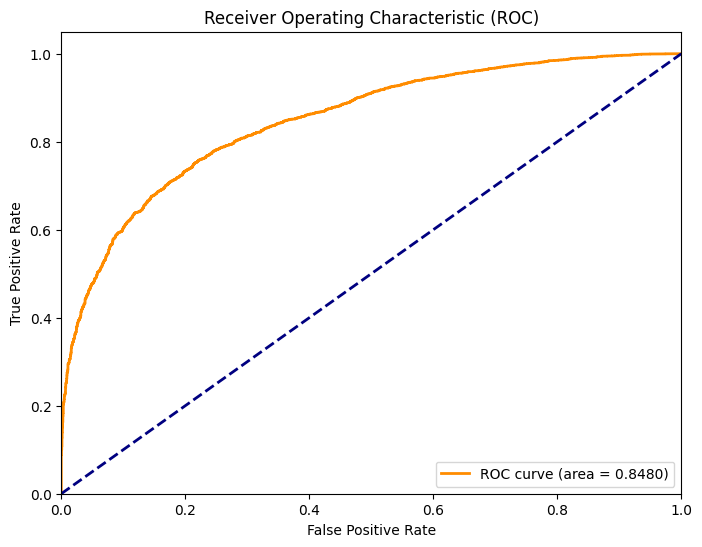

ROC AUC Score (XGBoost final model): 0.8480


In [ ]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_pred_proba = final_model.predict_proba(X_val)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba) # Changed this line
roc_auc_xgboost = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_xgboost:.4f})') # Changed this line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print(f"ROC AUC Score (XGBoost final model): {roc_auc_xgboost:.4f}")

## **Confusion Matrix**

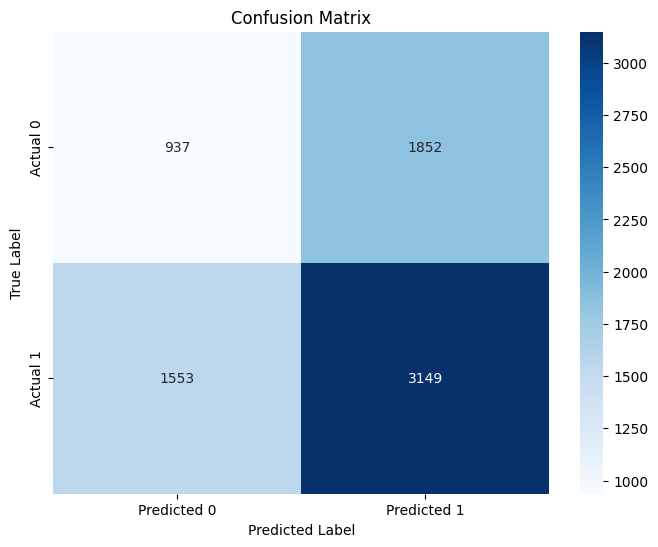

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'y_val' and 'cs_preds' are defined from your previous code
cm = confusion_matrix(y_val, cs_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## **SHAP**

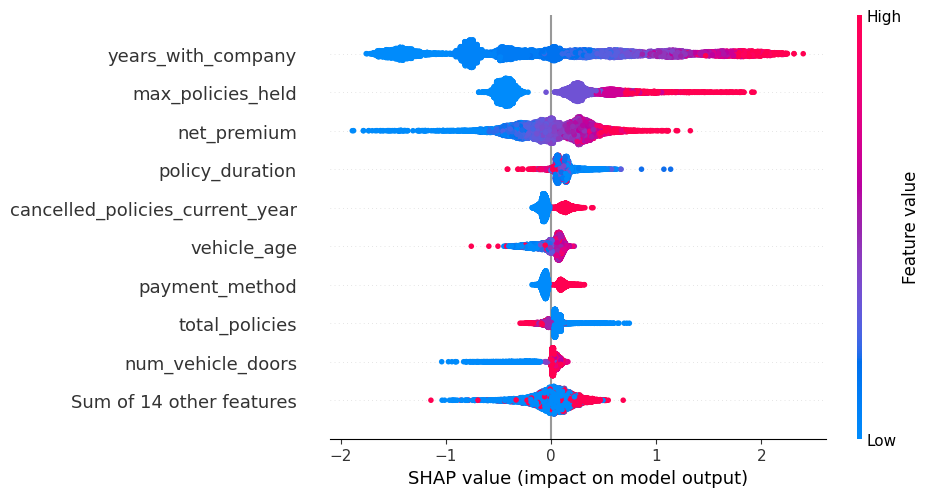

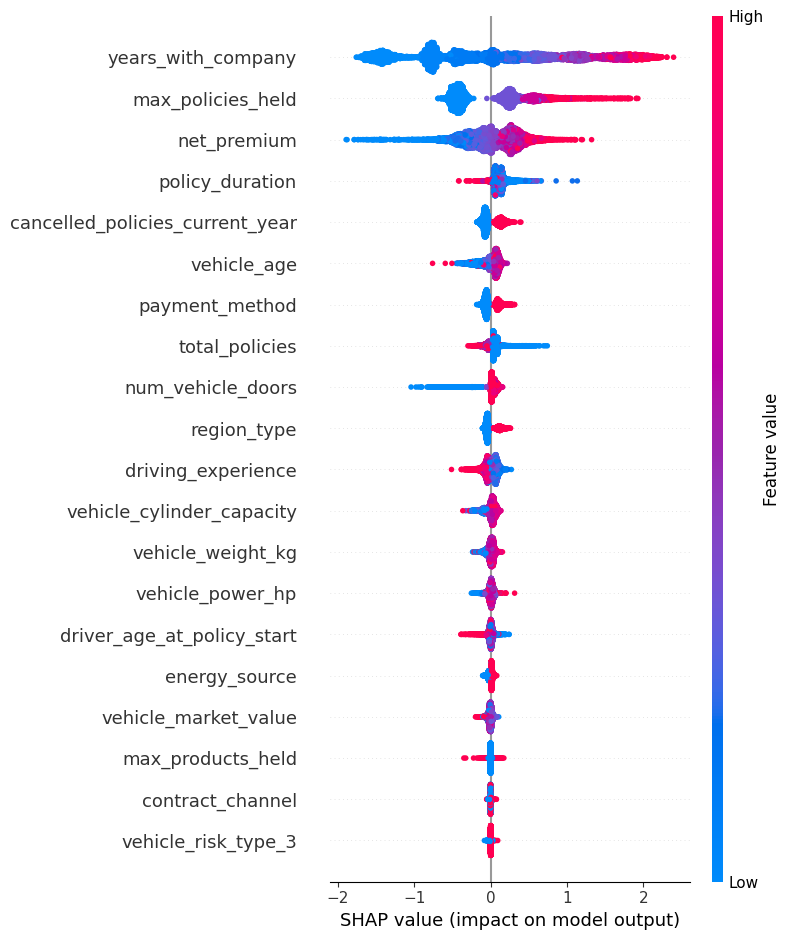

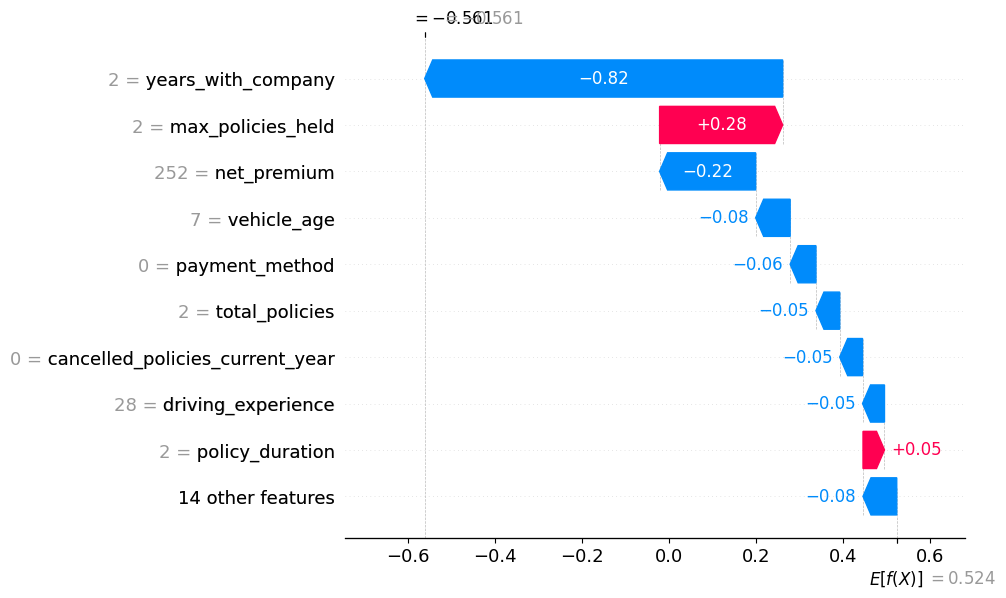

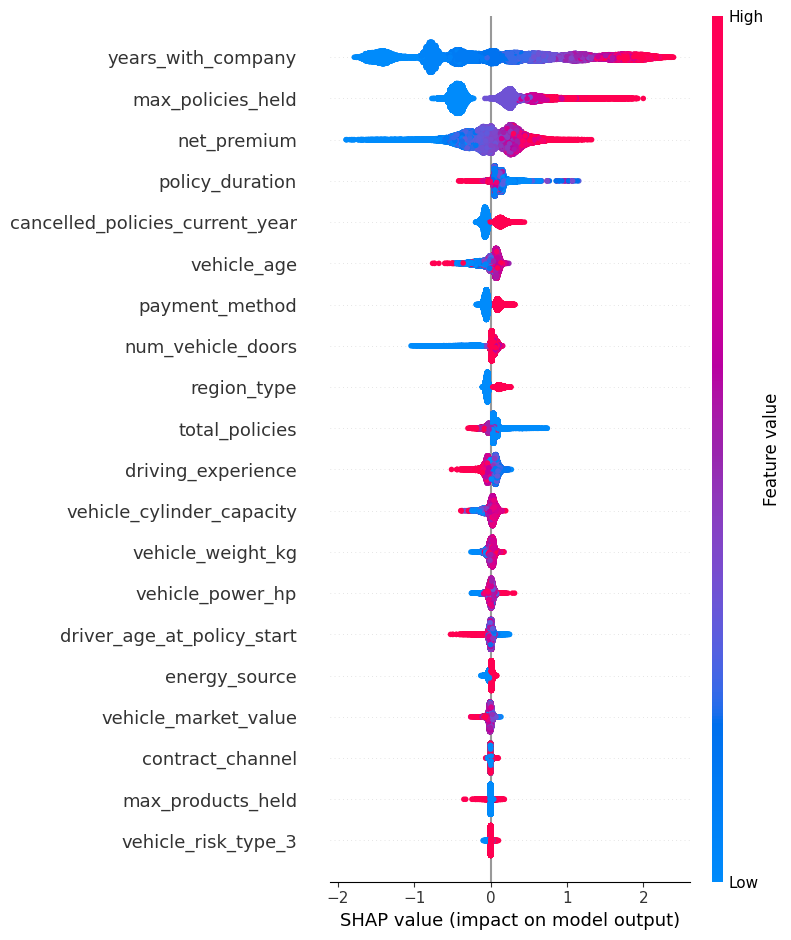

In [ ]:
import shap

# Assuming 'xgb_cs' is the best estimator from the hyperparameter tuning
explainer = shap.Explainer(xgb_cs)
shap_values = explainer(X_val)

# Visualize SHAP values
shap.plots.beeswarm(shap_values)
shap.summary_plot(shap_values, X_val)

# SHAP for individual predictions
i = 0
shap.plots.waterfall(shap_values[i])

# SHAP values for the entire dataset
shap_values_full = explainer(X)
shap.summary_plot(shap_values_full, X)


 **Bar Plot of Average Feature Importance**

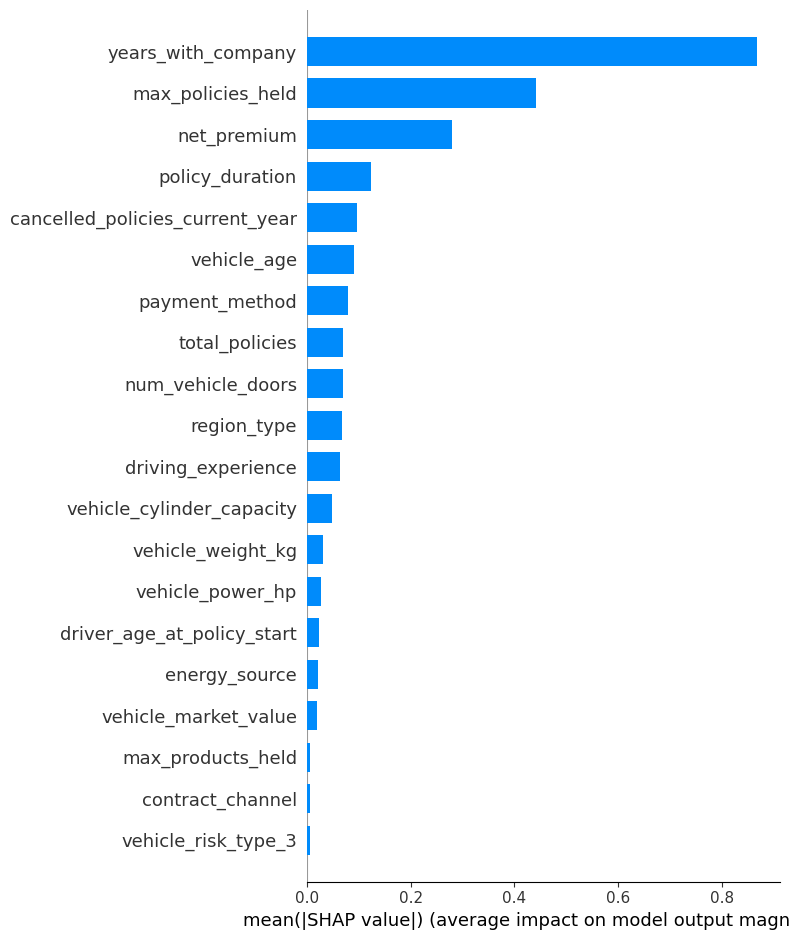

In [ ]:
import shap

# Use the legacy TreeExplainer for CPU compatibility
explainer = shap.TreeExplainer(xgb_cs)
shap_values = explainer.shap_values(X_val)

# Bar plot of average SHAP value magnitude
shap.summary_plot(shap_values, X_val, plot_type="bar")


**Feature Importance (XGBoost Native)**

This is different from SHAP — shows how often features are used in splits.

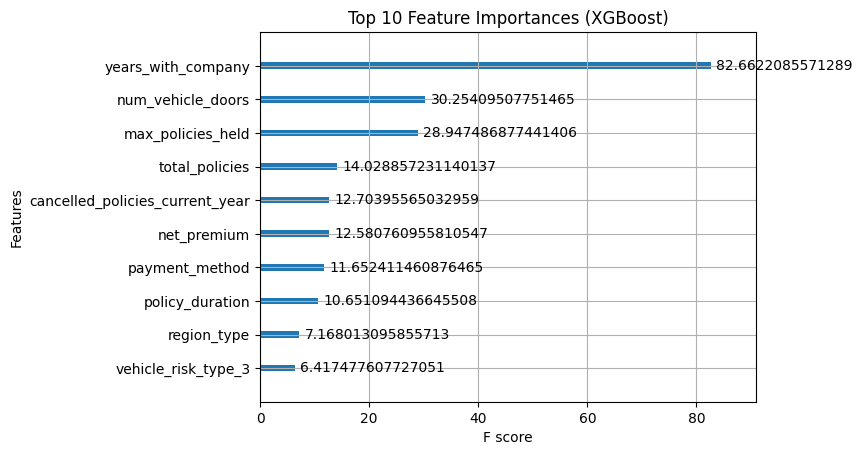

In [ ]:
from xgboost import plot_importance

plot_importance(xgb_cs, max_num_features=10, importance_type='gain')
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()


**Predicted Probability Histogram**

Show how confident your model is — helpful for understanding uncertainty.

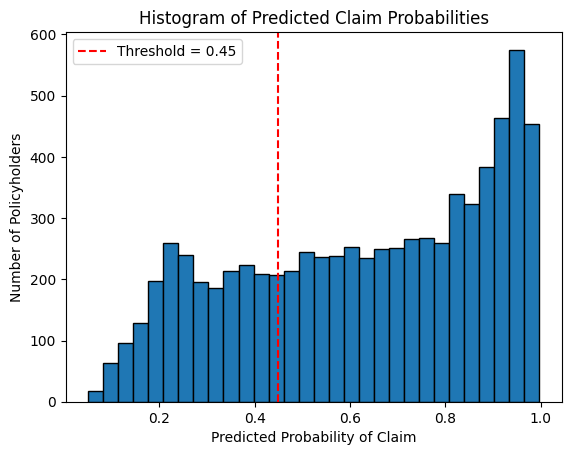

In [ ]:
plt.hist(cs_probs, bins=30, edgecolor='k')
plt.axvline(x=0.45, color='red', linestyle='--', label='Threshold = 0.45')
plt.xlabel('Predicted Probability of Claim')
plt.ylabel('Number of Policyholders')
plt.title('Histogram of Predicted Claim Probabilities')
plt.legend()
plt.show()


## **Handling Class Imbalance**

Use scale_pos_weight
Instead of SMOTE, XGBoost has a native way to handle imbalance:

In [ ]:
# Ratio = negative / positive
scale_pos_weight = (y == 0).sum() / (y == 1).sum()

xgb_cs = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)


In [ ]:
xgb_cs.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report

# Predict on validation set
cs_probs = xgb_cs.predict_proba(X_val)[:, 1]
cs_preds = xgb_cs.predict(X_val)

# ROC-AUC and classification report
roc_auc = roc_auc_score(y_val, cs_probs)
print(f"📊 ROC-AUC Score (XGBoost w/ scale_pos_weight): {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, cs_preds))


📊 ROC-AUC Score (XGBoost w/ scale_pos_weight): 0.8228

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.75      0.68      2789
           1       0.83      0.73      0.78      4702

    accuracy                           0.74      7491
   macro avg       0.73      0.74      0.73      7491
weighted avg       0.76      0.74      0.75      7491



In [ ]:
custom_preds = (cs_probs >= 0.45).astype(int)
print("\nClassification Report (Threshold = 0.45):")
print(classification_report(y_val, custom_preds))



Classification Report (Threshold = 0.45):
              precision    recall  f1-score   support

           0       0.65      0.70      0.68      2789
           1       0.82      0.78      0.80      4702

    accuracy                           0.75      7491
   macro avg       0.73      0.74      0.74      7491
weighted avg       0.75      0.75      0.75      7491



ROC AUC Score: 0.8227662328412693


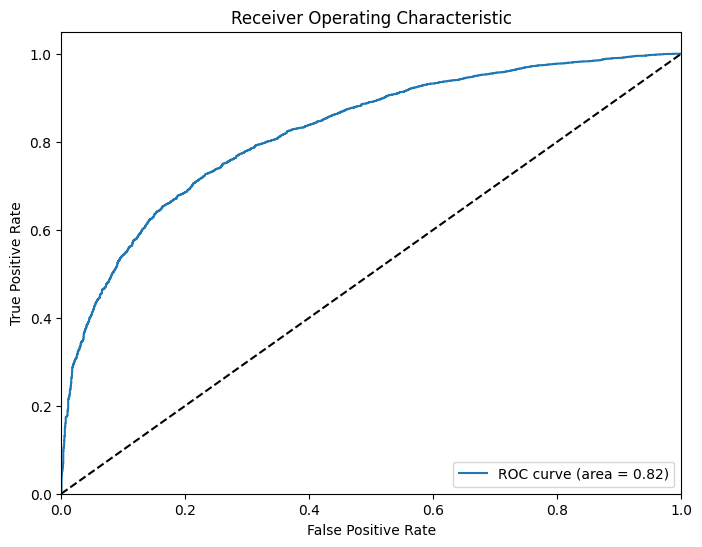

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Predict probabilities for the positive class
y_probs = xgb_cs.predict_proba(X_val)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_val, y_probs)
print(f"ROC AUC Score: {roc_auc}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# **Neural Networks**

## **Neural Networks Classification Overview**

Multiple feedforward neural networks were developed to predict Claim Status (CS), iterating on architecture depth, optimizer tuning, and performance metrics. The workflow included baseline modeling, metric monitoring, architectural enhancements, and early stopping.

### 1. Baseline Neural Network
- Architecture: 2 hidden layers with 64 and 32 neurons using ReLU activation.
- Output layer: sigmoid activation (binary classification).
- Optimizer: Adam.
- Loss: Binary crossentropy.
- Metric: Accuracy and ROC-AUC.
- Validation split: 20%.

The baseline model achieved:
- **ROC-AUC Score: 0.81**
- Demonstrated strong performance out-of-the-box without any tuning.

### 2. ROC-AUC Metric Integration
The model was recompiled with `tf.keras.metrics.AUC()` as an evaluation metric. ROC-AUC remained stable at **0.81**, confirming that the architecture and training configuration were already effective.

### 3. Deeper Architecture
- Architecture: 512 → 256 → 128 → 64 → 32 → 1
- Maintained ReLU activations and sigmoid output.
- Optimizer: Adam.
- ROC-AUC stayed around **0.81**, showing **no clear gain** from additional layers.

Note: One trial mistakenly used `softmax` in the output layer (incorrect for binary classification) but was later corrected to `sigmoid`.

### 4. Early Stopping Integration
To reduce overfitting and improve generalization:
- `EarlyStopping` was added, monitoring validation AUC with patience = 2
- Best weights were restored

This stabilized the training process and retained peak ROC-AUC performance.

### 5. ROC Curve Visualization
ROC curves were plotted with true positive vs. false positive rates. Curves showed good classifier performance, with area under the curve (AUC) near 0.81.

### Summary
- The baseline neural network already achieved **strong performance (ROC-AUC = 0.81)**.
- Deeper architectures and early stopping stabilized results but didn’t significantly improve metrics.
- Compared to the best-performing XGBoost model (ROC-AUC ≈ 0.84), the neural network was competitive but slightly lower.


## **Baseline Model**

Epoch 1/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6915 - loss: 0.5765 - val_accuracy: 0.7457 - val_loss: 0.5131
Epoch 2/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7416 - loss: 0.5094 - val_accuracy: 0.7480 - val_loss: 0.5086
Epoch 3/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7498 - loss: 0.5018 - val_accuracy: 0.7525 - val_loss: 0.5029
Epoch 4/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7524 - loss: 0.4945 - val_accuracy: 0.7553 - val_loss: 0.5022
Epoch 5/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7526 - loss: 0.4942 - val_accuracy: 0.7478 - val_loss: 0.5104
Epoch 6/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7542 - loss: 0.4917 - val_accuracy: 0.7505 - val_loss: 0.5033
Epoch 7/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7616 - loss: 0.4884 - val_accuracy: 0.7508 - val_loss: 0.5008
Epoch 8/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7628 - loss: 0.4857 - val_accuracy: 0.

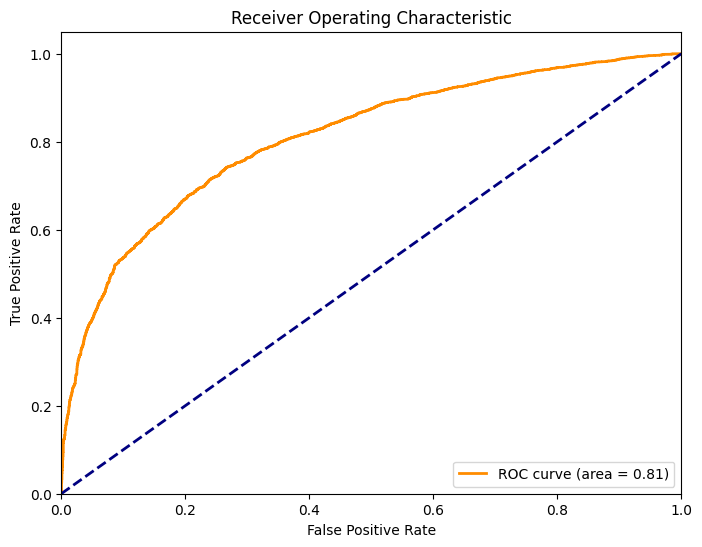

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_nn.shape[1],)),  # Input layer
    layers.Dense(32, activation='relu'),  # Hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer (sigmoid for binary classification)
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train_nn, y_train, epochs=30, batch_size=32, validation_split=0.2) # Adjust epochs and batch_size as needed

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
y_pred_prob = model.predict(X_test_nn)
y_pred = (y_pred_prob > 0.5).astype(int) # Convert probabilities to class labels

#Further analysis, confusion matrix, etc. can be done here.

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Assuming y_test and y_pred_prob are already defined from the previous code

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC: {roc_auc:.4f}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



## **Using ROC-AUC**

Epoch 1/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc_1: 0.7564 - loss: 0.5598 - val_auc_1: 0.8063 - val_loss: 0.5149
Epoch 2/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - auc_1: 0.8015 - loss: 0.5165 - val_auc_1: 0.8125 - val_loss: 0.5095
Epoch 3/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - auc_1: 0.8127 - loss: 0.5041 - val_auc_1: 0.8162 - val_loss: 0.5023
Epoch 4/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - auc_1: 0.8193 - loss: 0.4987 - val_auc_1: 0.8149 - val_loss: 0.5090
Epoch 5/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - auc_1: 0.8223 - loss: 0.4972 - val_auc_1: 0.8166 - val_loss: 0.5032
Epoch 6/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc_1: 0.8198 - loss: 0.4981 - val_auc_1: 0.8168 - val_loss: 0.5020
Epoch 7/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - auc_1: 0.8231 - loss: 0.4924 - val_auc_1: 0.8140 - val_loss: 0.5049
Epoch 8/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc_1: 0.8257 - loss: 0.4912 - val_auc_1: 0.8153 - val_loss: 0.5059
Epoch 9/30
749/749 ━━━━━

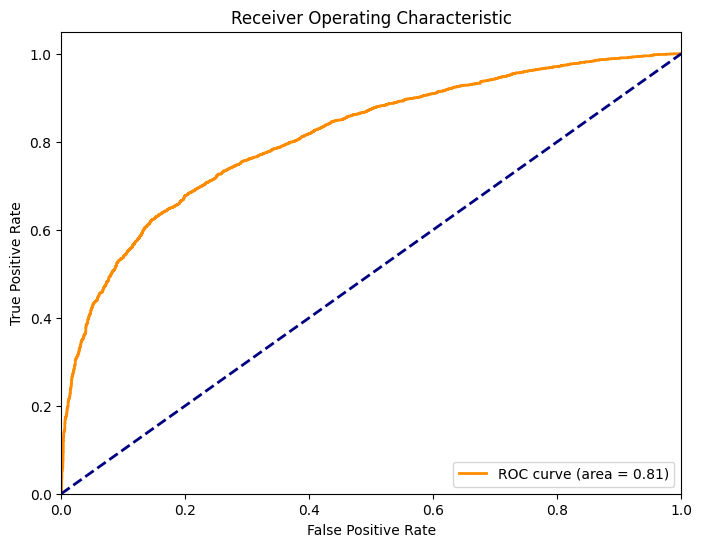

In [ ]:
# Define the model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_nn.shape[1],)),  # Input layer
    layers.Dense(32, activation='relu'),  # Hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer (sigmoid for binary classification)
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC()])

# Train the model
model.fit(X_train_nn, y_train, epochs=30, batch_size=32, validation_split=0.2) # Adjust epochs and batch_size as needed

# Evaluate the model
loss, accuracy = model.evaluate(X_test_nn, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
y_pred_prob = model.predict(X_test_nn)
y_pred = (y_pred_prob > 0.5).astype(int) # Convert probabilities to class labels

#Further analysis, confusion matrix, etc. can be done here.

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC: {roc_auc:.4f}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## **Adding Layers**

Epoch 1/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - auc_2: 0.5000 - loss: 0.5538 - val_auc_2: 0.5000 - val_loss: 0.5073
Epoch 2/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - auc_2: 0.5000 - loss: 0.5172 - val_auc_2: 0.5000 - val_loss: 0.5110
Epoch 3/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - auc_2: 0.5000 - loss: 0.5095 - val_auc_2: 0.5000 - val_loss: 0.5080
Epoch 4/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - auc_2: 0.5000 - loss: 0.5030 - val_auc_2: 0.5000 - val_loss: 0.5074
Epoch 5/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - auc_2: 0.5000 - loss: 0.5022 - val_auc_2: 0.5000 - val_loss: 0.5077
Epoch 6/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - auc_2: 0.5000 - loss: 0.4938 - val_auc_2: 0.5000 - val_loss: 0.5003
Epoch 7/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - auc_2: 0.5000 - loss: 0.4933 - val_auc_2: 0.5000 - val_loss: 0.5038
Epoch 8/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - auc_2: 0.5000 - loss: 0.4866 - val_auc_2: 0.5000 - val_loss: 0.5050
Epoch 9/30
749/749 ━━━━━

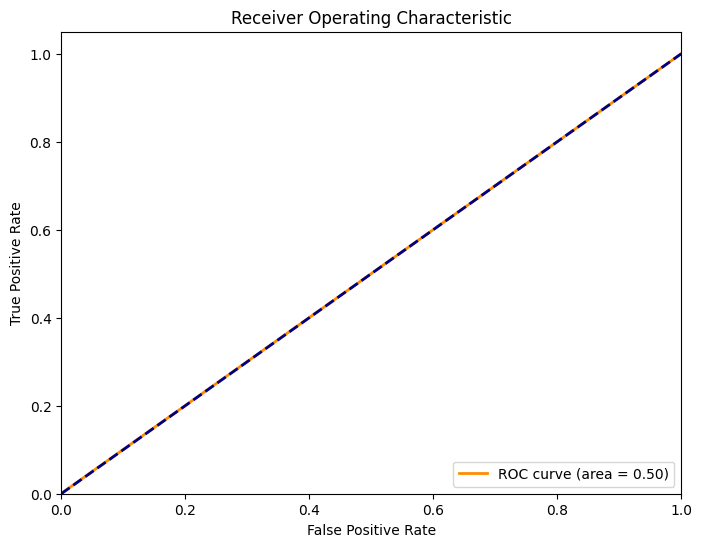

In [ ]:
# Define the model
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=(X_train_nn.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),  # Input layer
    layers.Dense(32, activation='relu'),  # Hidden layer
    layers.Dense(1, activation='softmax')  # Output layer (sigmoid for binary classification)
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC()])

# Train the model
model.fit(X_train_nn, y_train, epochs=30, batch_size=32, validation_split=0.2) # Adjust epochs and batch_size as needed

# Evaluate the model
loss, accuracy = model.evaluate(X_test_nn, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
y_pred_prob = model.predict(X_test_nn)
y_pred = (y_pred_prob > 0.5).astype(int) # Convert probabilities to class labels

#Further analysis, confusion matrix, etc. can be done here.
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC: {roc_auc:.4f}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## **Changing to Adam**

Epoch 1/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - auc_3: 0.7618 - loss: 0.5509 - val_auc_3: 0.8116 - val_loss: 0.5106
Epoch 2/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - auc_3: 0.8082 - loss: 0.5121 - val_auc_3: 0.8176 - val_loss: 0.5019
Epoch 3/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - auc_3: 0.8152 - loss: 0.5035 - val_auc_3: 0.8147 - val_loss: 0.5137
Epoch 4/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - auc_3: 0.8130 - loss: 0.5043 - val_auc_3: 0.8171 - val_loss: 0.5039
Epoch 5/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - auc_3: 0.8216 - loss: 0.4984 - val_auc_3: 0.8172 - val_loss: 0.5049
Epoch 6/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - auc_3: 0.8203 - loss: 0.4966 - val_auc_3: 0.8178 - val_loss: 0.5022
Epoch 7/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - auc_3: 0.8315 - loss: 0.4857 - val_auc_3: 0.8137 - val_loss: 0.5128
Epoch 8/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - auc_3: 0.8253 - loss: 0.4898 - val_auc_3: 0.8136 - val_loss: 0.5094
Epoch 9/30
749/749 ━━━━━

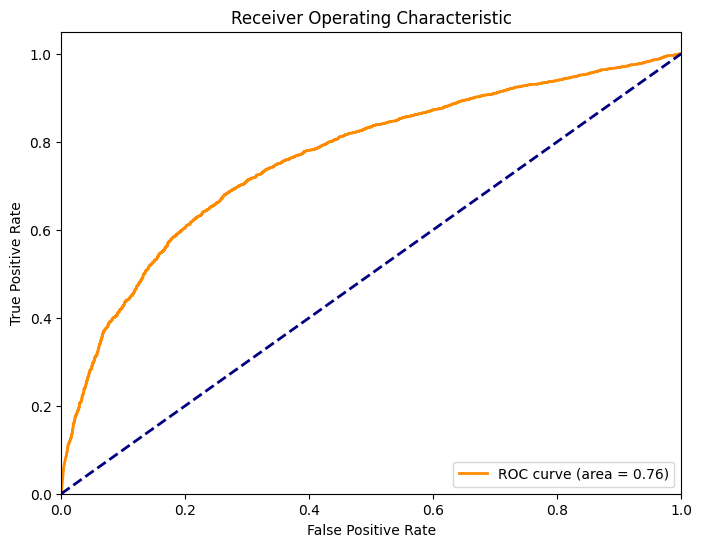

In [ ]:

# Define the model
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=(X_train_nn.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),  # Input layer
    layers.Dense(32, activation='relu'),  # Hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer (sigmoid for binary classification)
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC()])

# Train the model
model.fit(X_train_nn, y_train, epochs=30, batch_size=32, validation_split=0.2) # Adjust epochs and batch_size as needed

# Evaluate the model
loss, accuracy = model.evaluate(X_test_nn, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
y_pred_prob = model.predict(X_test_nn)
y_pred = (y_pred_prob > 0.5).astype(int) # Convert probabilities to class labels

#Further analysis, confusion matrix, etc. can be done here.


import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Assuming y_test and y_pred_prob are already defined from the previous code

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC: {roc_auc:.4f}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



Epoch 1/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - auc_4: 0.7641 - loss: 0.5531 - val_auc_4: 0.8127 - val_loss: 0.5075
Epoch 2/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - auc_4: 0.8143 - loss: 0.5056 - val_auc_4: 0.8117 - val_loss: 0.5080
Epoch 3/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - auc_4: 0.8192 - loss: 0.4997 - val_auc_4: 0.8125 - val_loss: 0.5072
Epoch 4/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - auc_4: 0.8201 - loss: 0.4997 - val_auc_4: 0.8157 - val_loss: 0.5079
Epoch 5/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - auc_4: 0.8175 - loss: 0.5021 - val_auc_4: 0.8180 - val_loss: 0.5028
Epoch 6/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - auc_4: 0.8231 - loss: 0.4950 - val_auc_4: 0.8183 - val_loss: 0.5025
Epoch 7/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - auc_4: 0.8281 - loss: 0.4878 - val_auc_4: 0.8162 - val_loss: 0.5047
Epoch 8/30
749/749 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - auc_4: 0.8330 - loss: 0.4832 - val_auc_4: 0.8124 - val_loss: 0.5072
Epoch 9/30
749/749 ━━━━━

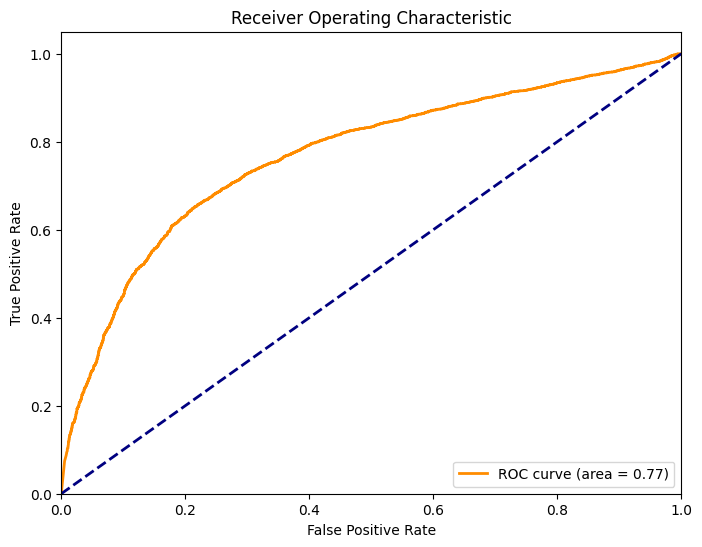

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping
# Define the model
model2 = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=(X_train_nn.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),  # Input layer
    layers.Dense(32, activation='relu'),  # Hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer (sigmoid for binary classification)
])

# Compile the model
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC()])

early_stopping = EarlyStopping(monitor='val_auc', patience=2, restore_best_weights=True, mode = 'max')

# Train the model
model2.fit(X_train_nn, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks = [early_stopping]) # Adjust epochs and batch_size as needed

# Evaluate the model
loss, accuracy = model2.evaluate(X_test_nn, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
y_pred_prob_2 = model2.predict(X_test_nn)
y_pred_2 = (y_pred_prob > 0.5).astype(int) # Convert probabilities to class labels

#Further analysis, confusion matrix, etc. can be done here.


import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Assuming y_test and y_pred_prob are already defined from the previous code

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_prob_2)
print(f"ROC AUC: {roc_auc:.4f}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_2)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



# **Random Forest**

## **Random Forest Classifier Overview**

A Random Forest Classifier was trained to predict claim status (CS) using the processed features from the insurance dataset. The baseline model used 100 estimators and a maximum depth of 6, yielding decent performance. To improve upon this, we performed extensive hyperparameter tuning using both `RandomizedSearchCV` and `GridSearchCV`, optimizing key parameters such as tree depth, number of estimators, split thresholds, and class weights.

The **best tuned Random Forest model** achieved a strong ROC-AUC score of **0.8290**, indicating robust ability to distinguish between claim and non-claim outcomes.

**Classification Report (Tuned RF):**
- Precision (Class 1): 0.84  
- Recall (Class 1): 0.74  
- F1-score (Class 1): 0.79  
- Accuracy: 0.75  
- ROC-AUC: 0.8290

To address class imbalance and potentially improve minority class recall, we applied **SMOTE (Synthetic Minority Oversampling Technique)** during training. The resulting model had a slightly lower ROC-AUC of **0.8238**, but improved balance in recall and F1-scores between classes.

**Classification Report (RF + SMOTE):**
- Precision (Class 1): 0.83  
- Recall (Class 1): 0.77  
- F1-score (Class 1): 0.80  
- Accuracy: 0.75  
- ROC-AUC: 0.8238

Overall, the Random Forest model with tuning—and optionally with SMOTE—was among the top-performing classifiers in our modeling pipeline for CS.


## **Baseline Model**

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report

# Predict with best estimator
cs_preds = rf_cs.predict(X_val)
cs_probs = rf_cs.predict_proba(X_val)[:, 1]

# Evaluate
roc_auc = roc_auc_score(y_val, cs_probs)
print(f"🎯 ROC-AUC Score (Tuned Random Forest - CS): {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, cs_preds))


🎯 ROC-AUC Score (Tuned Random Forest - CS): 0.8290

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.75      0.69      2736
           1       0.84      0.74      0.79      4755

    accuracy                           0.75      7491
   macro avg       0.73      0.75      0.74      7491
weighted avg       0.76      0.75      0.75      7491



ROC AUC Score: 0.8289691214541788


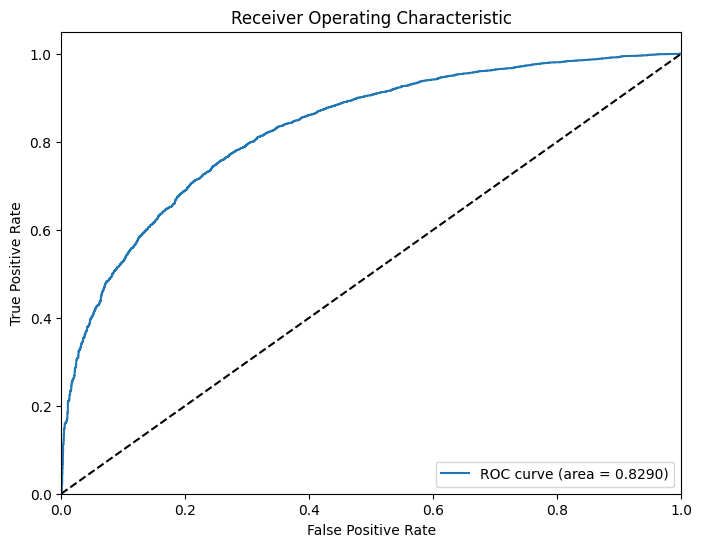

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_probs = rf_cs.predict_proba(X_val)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_val, y_probs)
print(f"ROC AUC Score: {roc_auc}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## **SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

rf_cs.fit(X_resampled, y_resampled)


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report

# Predict on original validation set
cs_preds = rf_cs.predict(X_val)
cs_probs = rf_cs.predict_proba(X_val)[:, 1]

# Evaluate
roc_auc = roc_auc_score(y_val, cs_probs)
print(f"📈 ROC-AUC Score (RF + SMOTE): {roc_auc:.4f}")
print("\nClassification Report (RF + SMOTE):")
print(classification_report(y_val, cs_preds))


📈 ROC-AUC Score (RF + SMOTE): 0.8238

Classification Report (RF + SMOTE):
              precision    recall  f1-score   support

           0       0.64      0.72      0.68      2736
           1       0.83      0.77      0.80      4755

    accuracy                           0.75      7491
   macro avg       0.74      0.75      0.74      7491
weighted avg       0.76      0.75      0.75      7491



# **All Models Comparison**

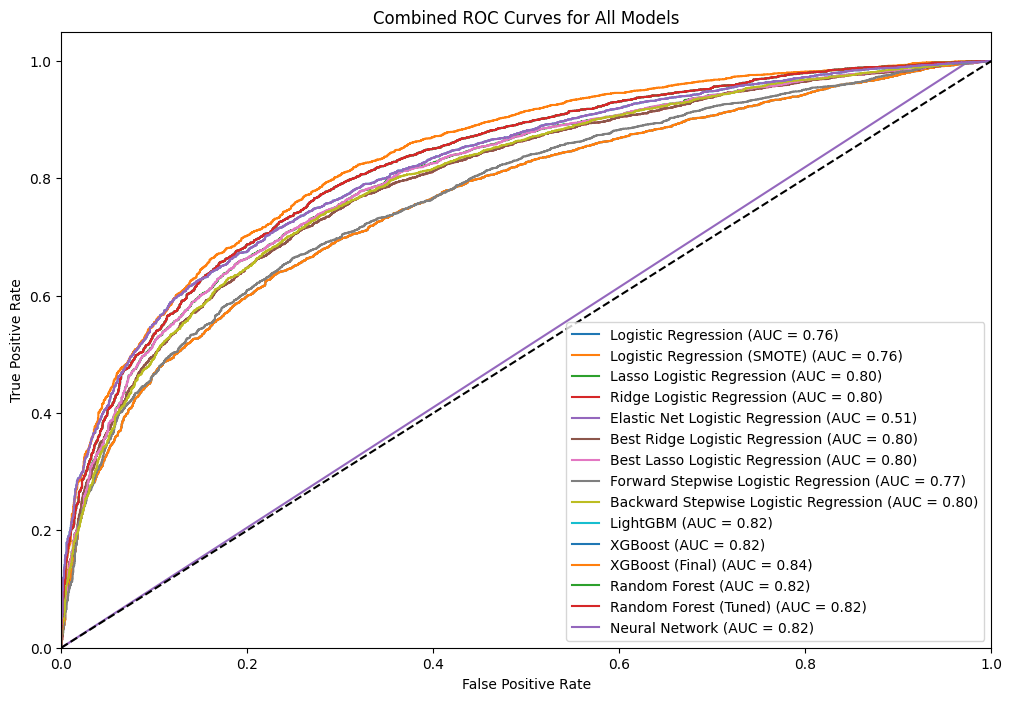

In [ ]:
from sklearn.metrics import roc_curve, auc


models = {
    'Logistic Regression': (y_test, y_pred_proba),
    'Logistic Regression (SMOTE)': (y_test, y_pred_proba_smote),
    'Lasso Logistic Regression': (y_test, y_pred_proba_lasso),
    'Ridge Logistic Regression': (y_test, y_pred_proba_ridge),
    'Elastic Net Logistic Regression': (y_test, y_pred_proba_elastic),
    'Best Ridge Logistic Regression': (y_test, y_pred_proba_best_ridge),
    'Best Lasso Logistic Regression':(y_test, y_pred_proba_best_lasso),
    'Forward Stepwise Logistic Regression': (y_test, y_pred_proba_selected),
    'Backward Stepwise Logistic Regression':(y_test, y_pred_proba_selected_backward),
    'LightGBM': (y_test, y_pred_prob), # Assuming y_pred_prob is defined for LightGBM
    'XGBoost': (y_val, cs_probs), # Assuming cs_probs is defined for XGBoost
    'XGBoost (Final)': (y_val, cs_probs_final), # Assuming cs_probs_final is defined for the final XGBoost model
    'Random Forest': (y_val, cs_probs), # Assuming cs_probs is defined for Random Forest
    'Random Forest (Tuned)': (y_val, cs_probs), # Assuming cs_probs is defined for tuned Random Forest
    #Add Neural Network here
    'Neural Network': (y_test, y_pred_prob)
}

plt.figure(figsize=(12, 8))

for model_name, (y_true, y_score) in models.items():
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curves for All Models')
plt.legend(loc='lower right')
plt.show()


# **EDA Visualizations**

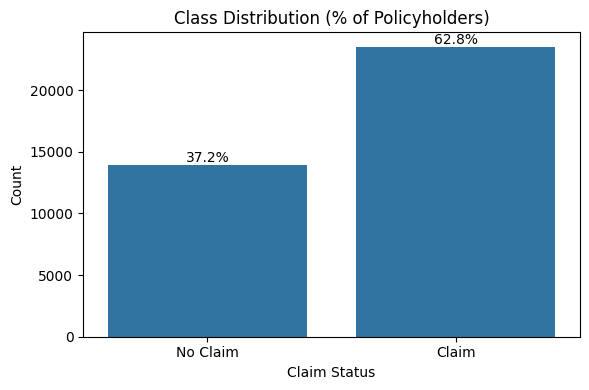

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Map 0/1 → No Claim/Claim
train_data['CS_label'] = train_data['CS'].map({0: 'No Claim', 1: 'Claim'})

# Plot
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='CS_label', data=train_data)
plt.title("Class Distribution (% of Policyholders)")
plt.xlabel("Claim Status")
plt.ylabel("Count")

# Get counts in correct order
cs_counts = train_data['CS_label'].value_counts(normalize=True).reindex(['No Claim', 'Claim']) * 100

# Add percent text to each bar
for i, v in enumerate(cs_counts):
    plt.text(i, train_data['CS_label'].value_counts().reindex(['No Claim', 'Claim']).iloc[i],
             f"{v:.1f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()



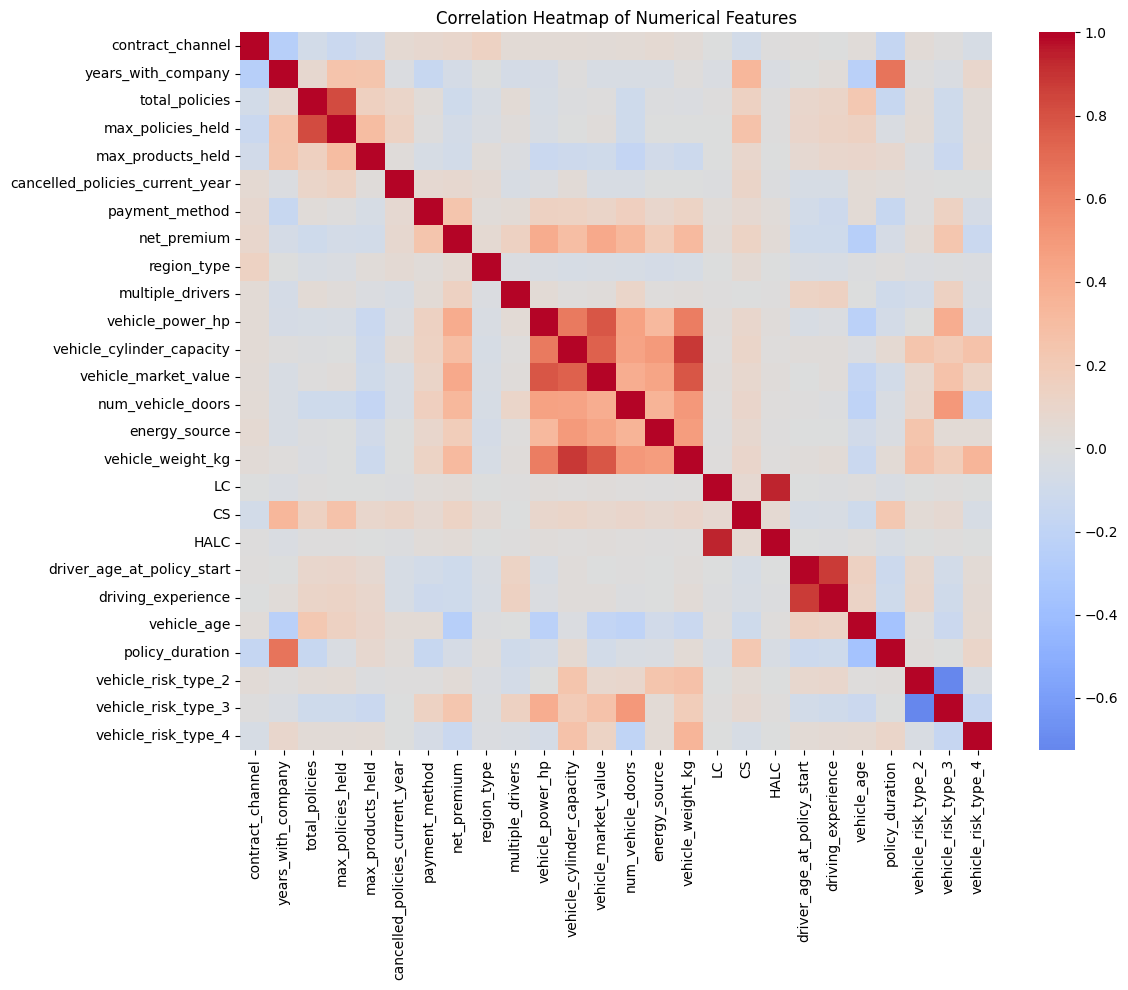

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(train_data.corr(), annot=False, cmap='coolwarm', fmt='.2f', center=0)
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()


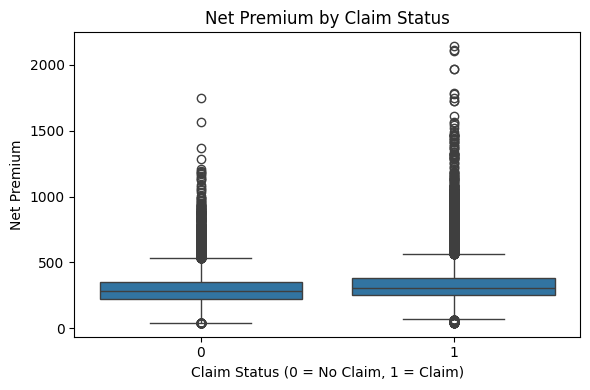

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='CS', y='net_premium', data=train_data)
plt.title("Net Premium by Claim Status")
plt.xlabel("Claim Status (0 = No Claim, 1 = Claim)")
plt.ylabel("Net Premium")
plt.tight_layout()
plt.show()


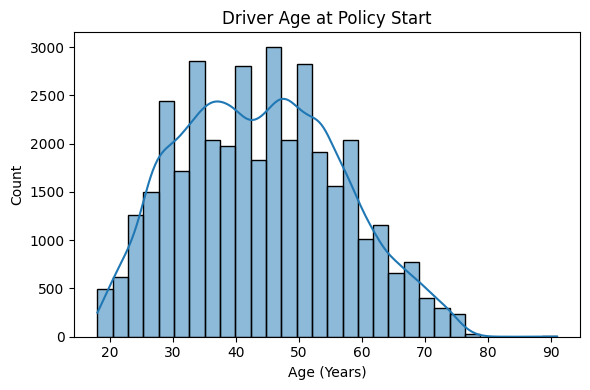

In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(train_data['driver_age_at_policy_start'], bins=30, kde=True)
plt.title("Driver Age at Policy Start")
plt.xlabel("Age (Years)")
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Correlation Heatmap (Selected Features)')

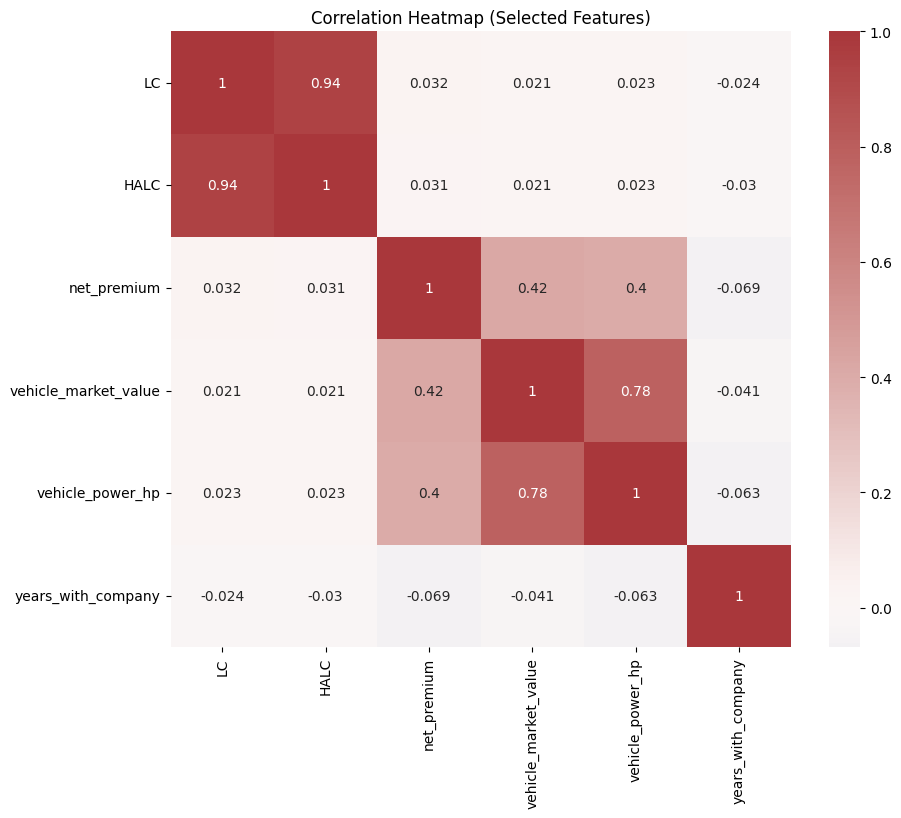

In [ ]:
plt.figure(figsize=(10, 8))
selected_features = train_data[['LC', 'HALC', 'net_premium', 'vehicle_market_value', 'vehicle_power_hp', 'years_with_company']]
sns.heatmap(selected_features.corr(), annot=True, cmap='vlag', center=0)
plt.title("Correlation Heatmap (Selected Features)")


In [ ]:
# Define a function to bin net_premium
def bin_net_premium(df):
    return pd.cut(
        df['net_premium'],
        bins=[-float('inf'), 300, 700, float('inf')],
        labels=['low', 'medium', 'high']
    )

# Apply to both train and test sets
train_data['net_premium_bin'] = bin_net_premium(train_data)
test_data['net_premium_bin'] = bin_net_premium(test_data)


In [ ]:
# Map to numeric bins if using in XGBoost
bin_map = {'low': 0, 'medium': 1, 'high': 2}
train_data['net_premium_bin'] = train_data['net_premium_bin'].map(bin_map)
test_data['net_premium_bin'] = test_data['net_premium_bin'].map(bin_map)


In [ ]:
train_data.drop(columns=['net_premium'], inplace=True)
test_data.drop(columns=['net_premium'], inplace=True)


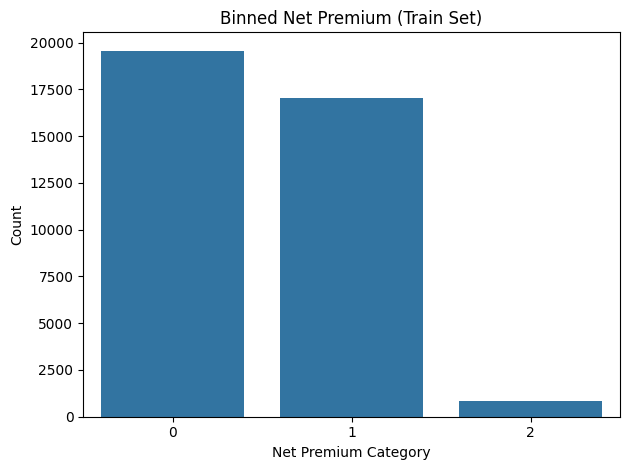

In [ ]:
sns.countplot(x='net_premium_bin', data=train_data)
plt.title("Binned Net Premium (Train Set)")
plt.xlabel("Net Premium Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


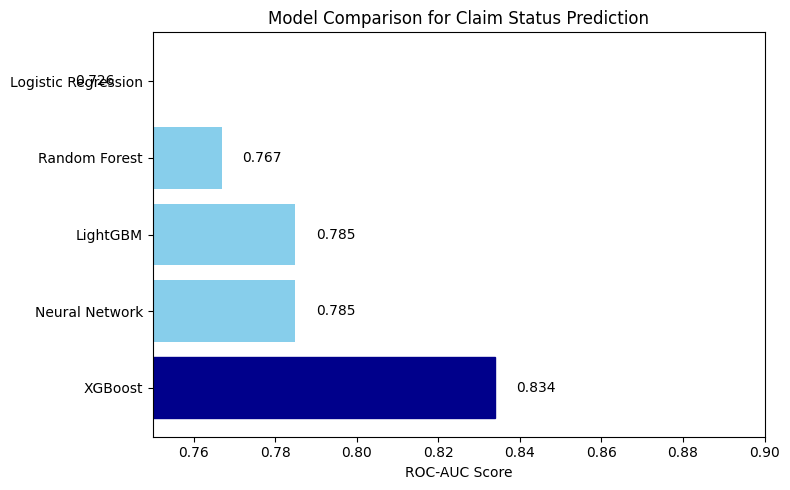

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example ROC-AUC scores
model_names = ['Logistic Regression', 'Random Forest', 'LightGBM', 'Neural Network', 'XGBoost']
roc_scores = [0.726, 0.767, 0.785, 0.785, 0.834]

# Create a simple bar plot
plt.figure(figsize=(8,5))
sns.barplot(x=roc_scores, y=model_names, palette='viridis')

# Highlight XGBoost bar
bars = plt.barh(model_names, roc_scores, color='skyblue')
bars[-1].set_color('darkblue')  # Make XGBoost darker

# Titles and labels
plt.xlabel('ROC-AUC Score')
plt.title('Model Comparison for Claim Status Prediction')
plt.xlim(0.75, 0.9)
for index, value in enumerate(roc_scores):
    plt.text(value + 0.005, index, f"{value}", va='center')

plt.tight_layout()
plt.show()


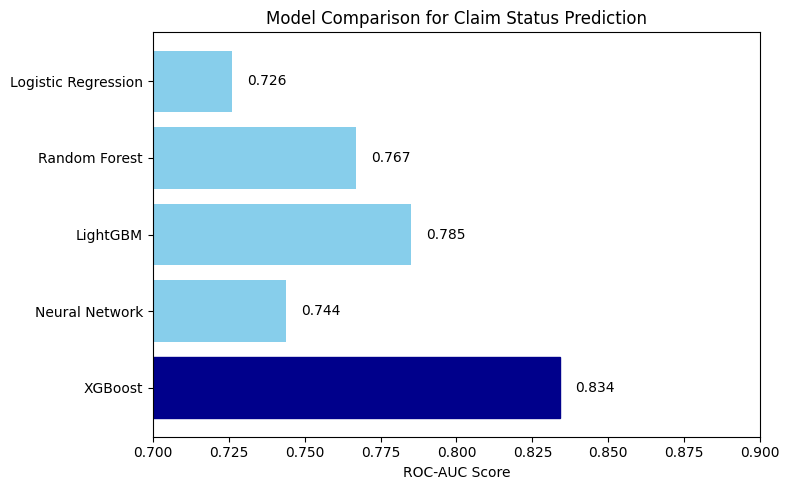

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ROC-AUC scores
model_names = ['Logistic Regression', 'Random Forest', 'LightGBM', 'Neural Network', 'XGBoost']
roc_scores = [0.726, 0.767, 0.785, 0.744, 0.834]

# Create a simple bar plot
plt.figure(figsize=(8,5))
sns.barplot(x=roc_scores, y=model_names, palette='viridis')

# Highlight XGBoost bar
bars = plt.barh(model_names, roc_scores, color='skyblue')
bars[-1].set_color('darkblue')  # Make XGBoost darker

# Titles and labels
plt.xlabel('ROC-AUC Score')
plt.title('Model Comparison for Claim Status Prediction')
plt.xlim(0.7, 0.9)
for index, value in enumerate(roc_scores):
    plt.text(value + 0.005, index, f"{value}", va='center')

plt.tight_layout()
plt.show()
